# TVB-ANNarchy: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## Izhikevich Spiking network model in ANNarchy

For every neuron $i$ in region node $n$ modelled in ANNarchy as a spiking network:

Membrane potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C $

$\;\;\;\;\;\;\;- g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e $

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_annarchy.config import *

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_annarchy")[0], "data")
simulation_mode = "stim_STN" # "rs" #  "stim_STN" # "stim_GPi" 
outputs_path = os.path.join(work_path, "outputs/outputs_Izhikevich_annarchy")
sim_mode_path = os.path.join(outputs_path, "TVBcortex", simulation_mode)
config = Config(output_base=sim_mode_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [2]:
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG


# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left
BG_opt_matrix_weights = np.zeros((5, 5))
conn_mode = "subject" # "average"
if conn_mode == "average":
    weights_maith = np.array([1.93, 3.56, 1.46, 4.51, 3.52, 2.30, 2.34, 3.78, 1.98, 
                             1.30, 1.82, 3.56, 3.02, 1.78, 1.36, 2.27, 4.13, 2.74, 3.27])*1e-3  # controls
#     weights_maith = np.array([3.27, 3.80, 2.65, 3.66, 3.06, 3.06, 3.25, 4.02, 3.32, 
#                             2.98, 3.45, 3.64, 2.50, 2.12, 2.86, 2.79, 3.96, 3.69, 3.87])*1e-3   # patients
    # probs_maith = ????
else:
    import scipy.io as sio
    conn_path = os.path.join(data_path, "basal_ganglia_conn_incl_cortex")
    weights=sio.loadmat(os.path.join(conn_path,"OutputSim_Patient01.mat")) # weights start from index 19
    weights_maith = weights["X"][0, 19:] # these are indices 19 till 37
    probs_maith = weights["X"][0, :19] # these are indices 0 till 18

wdSNGPi = BG_opt_matrix_weights[3, 1] = weights_maith[0]
wiSNGPe = BG_opt_matrix_weights[3, 0] = weights_maith[1]
wGPeSTN = BG_opt_matrix_weights[0, 2] = weights_maith[2]
wSTNGPe = BG_opt_matrix_weights[2, 0] = weights_maith[3]
wSTNGPi = BG_opt_matrix_weights[2, 1] = weights_maith[4]
wGPeGPi = BG_opt_matrix_weights[0, 1] = weights_maith[5]  
wGPiTh = BG_opt_matrix_weights[1, 4] = weights_maith[8]
wThdSN = BG_opt_matrix_weights[4, 3] = weights_maith[10] # Th -> dSN
    
sliceBGnet = slice(0,5)

wGPeGPe = weights_maith[6]   # "GPe" -> "GPe" 
wGPiGPi = weights_maith[7]   # "GPi" -> "GPi" 
wThiSN = weights_maith[9]    # "Eth" -> "IiSN" 

wdSNdSN = weights_maith[11]  # "IdSN" -> "IdSN" 
wiSNiSN = weights_maith[12]  # "IiSN" -> "IiSN" 
wCtxdSN = weights_maith[13]  # "CxE" -> "IdSN" 
wCtxiSN = weights_maith[14] # "CxE" -> "IiSN" 
wCtxSTN = weights_maith[15]  # "CxE" -> "Estn"
wCtxEtoI = weights_maith[16] # "CxE" -> "CxI"
wCtxItoE = weights_maith[17] # "CxI" -> "CxE"
wCtxItoI = weights_maith[18] # "CxI" -> "CxI"

pdSNGPi = probs_maith[0]
piSNGPe = probs_maith[1]
pGPeSTN = probs_maith[2]
pSTNGPe = probs_maith[3]
pSTNGPi = probs_maith[4]
pGPeGPi = probs_maith[5]  
pGPeGPe = probs_maith[6]  # "GPe" -> "GPe" 
pGPiGPi = probs_maith[7]  # "GPi" -> "GPi" 
pGPiTh = probs_maith[8]
pThiSN =  probs_maith[9]  # "Eth" -> "IiSN
pThdSN = probs_maith[10] # Th --> dSN
pdSNdSN = probs_maith[11] # "IdSN" -> "IdSN" 
piSNiSN = probs_maith[12] # "IiSN" -> "IiSN" 
pCtxdSN = probs_maith[13]  # "CxE" -> "IdSN" 
pCtxiSN = probs_maith[14] # "CxE" -> "IiSN" 
pCtxSTN = probs_maith[15]  # "CxE" -> "Estn"
# pCtxEtoI = probs_maith[16] # "CxE" -> "CxI"
# pCtxItoE = probs_maith[17] # "CxI" -> "CxE"
# pCtxItoI = probs_maith[18] # "CxI" -> "CxI"

loadedParams ={'dSNGPi_probs': probs_maith[0],
    	'dSNGPi_weights'  : weights_maith[0],
    	'iSNGPe_probs'   : probs_maith[1],
    	'iSNGPe_weights'  : weights_maith[1],
    	'GPeSTN_probs'   : probs_maith[2],
    	'GPeSTN_weights'  : weights_maith[2],
    	'STNGPe_probs'   : probs_maith[3],
    	'STNGPe_weights'  : weights_maith[3],
    	'STNGPi_probs'   : probs_maith[4],
    	'STNGPi_weights' : weights_maith[4],
    	'GPeGPi_probs'   : probs_maith[5],
    	'GPeGPi_weights'  : weights_maith[5],
    	'GPeGPe_probs'   : probs_maith[6],
    	'GPeGPe_weights'  : weights_maith[6],
    	'GPiGPi_probs'   : probs_maith[7],
    	'GPiGPi_weights'  : weights_maith[7],
    	'GPiThal_probs'   : probs_maith[8],
    	'GPiThal_weights'  : weights_maith[8],
    	'ThaliSN_probs'   : probs_maith[9],
    	'ThaliSN_weights'  : weights_maith[9],
    	'ThaldSN_probs'   : probs_maith[10],
    	'ThaldSN_weights'  : weights_maith[10],
    	'dSNdSN_probs'   : probs_maith[11],
    	'dSNdSN_weights'  : weights_maith[11],
    	'iSNiSN_probs'   : probs_maith[12],
    	'iSNiSN_weights'  : weights_maith[12],
    	'CtxdSN_probs'   : probs_maith[13],
    	'CtxdSN_weights'  : weights_maith[13],
    	'CtxiSN_probs'   : probs_maith[14],
    	'CtxiSN_weights'  : weights_maith[14],
    	'CtxSTN_probs'   : probs_maith[15],
    	'CtxSTN_weights'  : weights_maith[15],
    	'CtxECtxI_probs'    : probs_maith[16],
    	'CtxECtxI_weights'  : weights_maith[16],
    	'CtxICtxE_probs'    : probs_maith[17],
    	'CtxICtxE_weights'  : weights_maith[17],
    	'CtxICtxI_probs'   : probs_maith[18],
    	'CtxICtxI_weights'  : weights_maith[18],
        'CtxThal_weights': 0.0,
        'CtxThal_probs': 1.0}
print(loadedParams)

assert_loadedParams = dict(zip(loadedParams.values(), loadedParams.keys()))


{'dSNGPi_probs': 0.17029162198305128, 'dSNGPi_weights': 0.009132171887904406, 'iSNGPe_probs': 0.4074640914797783, 'iSNGPe_weights': 0.007663531694561243, 'GPeSTN_probs': 0.18478520214557648, 'GPeSTN_weights': 0.006760342903435231, 'STNGPe_probs': 0.4119542151689529, 'STNGPe_weights': 0.010754598900675774, 'STNGPi_probs': 0.2458414003252983, 'STNGPi_weights': 0.013566167578101158, 'GPeGPi_probs': 0.32317305132746693, 'GPeGPi_weights': 0.006238304376602173, 'GPeGPe_probs': 0.3238955348730087, 'GPeGPe_weights': 0.007731672264635564, 'GPiGPi_probs': 0.31747561842203137, 'GPiGPi_weights': 0.011985597293823957, 'GPiThal_probs': 0.25937364250421524, 'GPiThal_weights': 0.006650131419301033, 'ThaliSN_probs': 0.1753483198583126, 'ThaliSN_weights': 0.006984027139842511, 'ThaldSN_probs': 0.12791343107819556, 'ThaldSN_weights': 0.012284493483603, 'dSNdSN_probs': 0.44881010577082636, 'dSNdSN_weights': 0.008113504592329264, 'iSNiSN_probs': 0.20492168664932248, 'iSNiSN_weights': 0.013962633926421403, 

Connections of Thalami, Pallidum (GPe/i), Putamen and Caudate (Striatum) removed!:
 [[   0.    0. 2642.    0.  781.    0.  200.    0.]
 [   0.    0.    0. 1034.    0.   45.    0. 1025.]
 [2642.    0.    0.    0. 6058.    0. 1337.    0.]
 [   0. 1034.    0.    0.    0.  162.    0.  381.]
 [ 781.    0. 6058.    0.    0.    0. 1026.    0.]
 [   0.   45.    0.  162.    0.    0.    0.  989.]
 [ 200.    0. 1337.    0. 1026.    0.    0.    0.]
 [   0. 1025.    0.  381.    0.  989.    0.    0.]]
Removing BG -> Cortex connections with max:
1931.34115274226
Removing Cortex -> Thalamus connections with summed weight:
7385.840310132234
Removing BG <- Cortex connections with max:
1682.84151027352

Left cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:


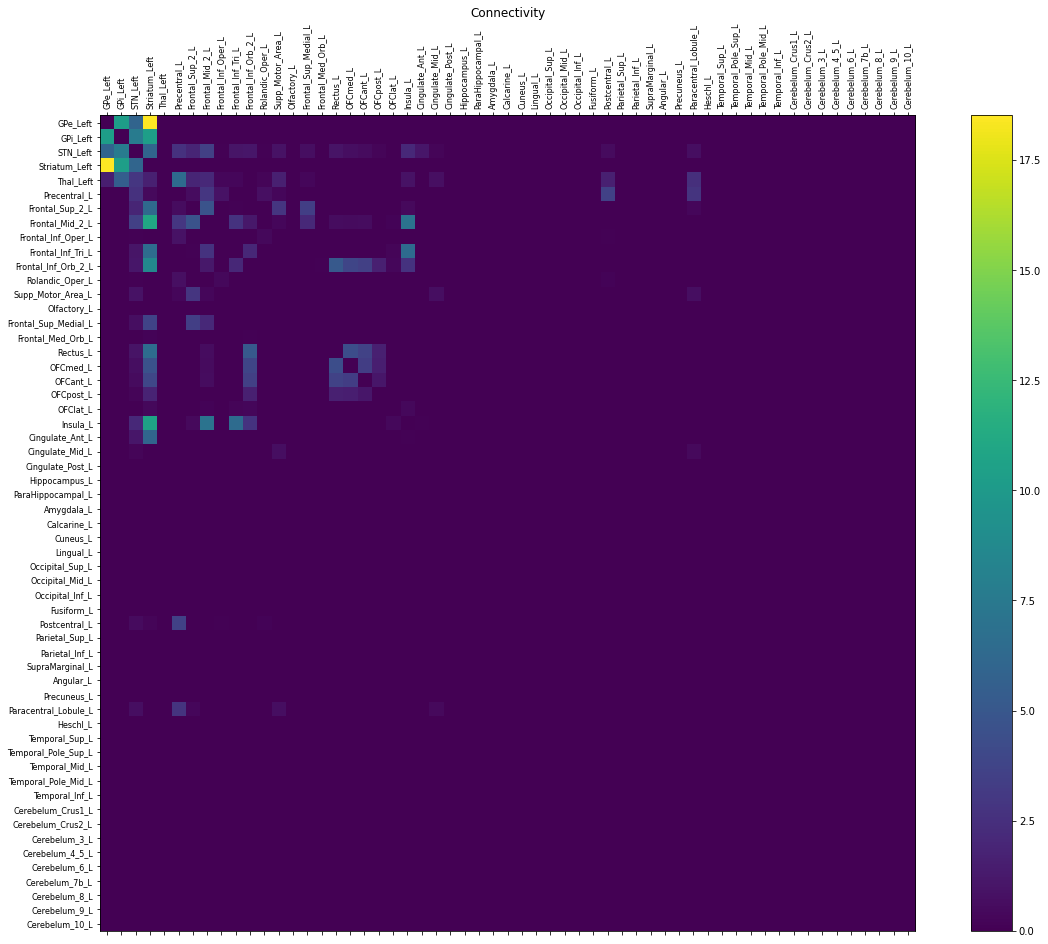

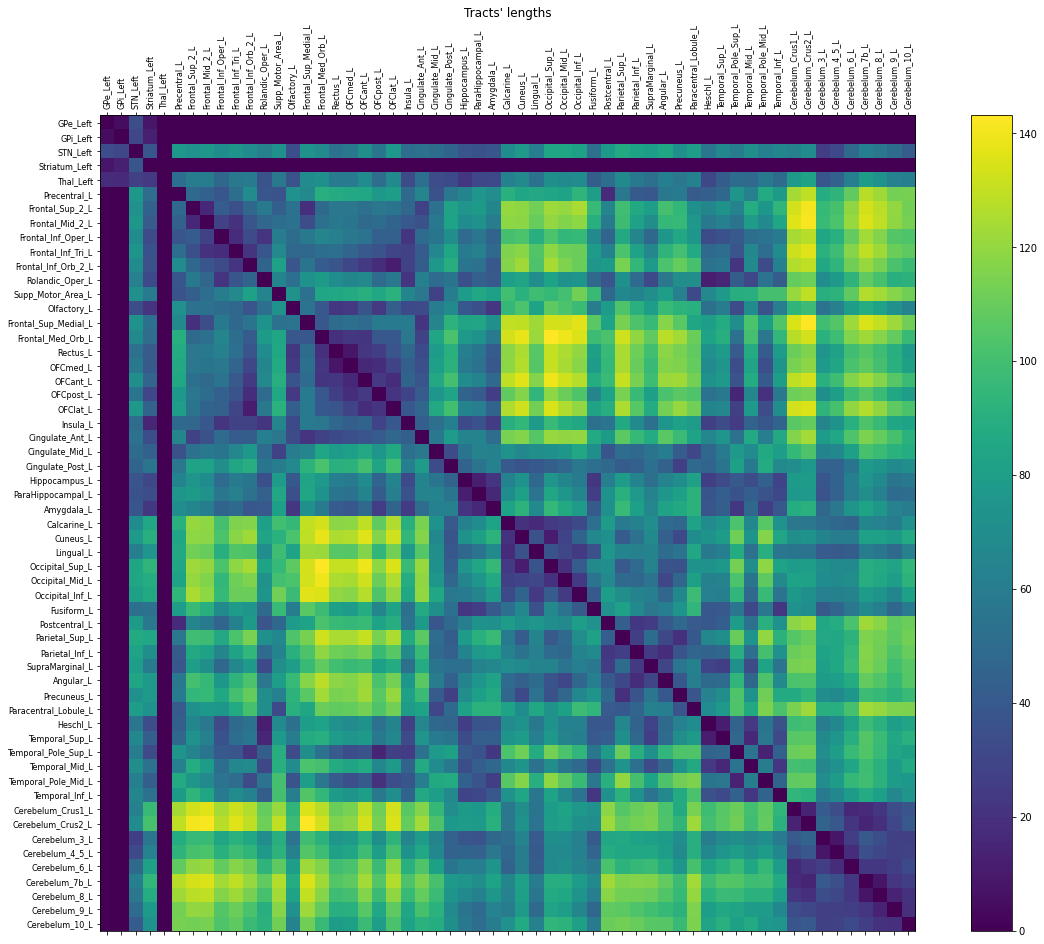

In [3]:
# Load full TVB connectome connectivity

conn_path = os.path.join(data_path, "basal_ganglia_conn")

#Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas
wTVB = np.loadtxt(os.path.join(conn_path, "conn_denis_weights.txt"))
cTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),usecols=range(1,3))
rlTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),dtype="str", usecols=(0,))
tlTVB = np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths.txt"))

# Remove the second Thalamus, Pallidum (GPe/i), Putamen and Caudate (Striatum):
inds_Th = (rlTVB.tolist().index("Thalamus_L"), rlTVB.tolist().index("Thalamus_R"))
inds_Pall = (rlTVB.tolist().index("Pallidum_L"), rlTVB.tolist().index("Pallidum_R"))
inds_Put = (rlTVB.tolist().index("Putamen_L"), rlTVB.tolist().index("Putamen_R"))
inds_Caud = (rlTVB.tolist().index("Caudate_L"), rlTVB.tolist().index("Caudate_R"))
inds_rm = inds_Th + inds_Pall + inds_Put + inds_Caud
print("Connections of Thalami, Pallidum (GPe/i), Putamen and Caudate (Striatum) removed!:\n", 
      wTVB[inds_rm, :][:, inds_rm])
wTVB = np.delete(wTVB, inds_rm, axis=0)
wTVB = np.delete(wTVB, inds_rm, axis=1)
tlTVB = np.delete(tlTVB, inds_rm, axis=0)
tlTVB = np.delete(tlTVB, inds_rm, axis=1)
rlTVB = np.delete(rlTVB, inds_rm, axis=0)
cTVB = np.delete(cTVB, inds_rm, axis=0)

number_of_regions = len(rlTVB)
speed = np.array([4.0])
min_tt = speed.item() * 0.1
sliceBG = [0, 1, 2, 3, 6, 7]
sliceCortex = slice(10, number_of_regions)

# Remove BG -> Cortex connections
print("Removing BG -> Cortex connections with max:")
print(wTVB[sliceBG, :][:, sliceCortex].max())
wTVB[sliceBG, sliceCortex] = 0.0
tlTVB[sliceBG, sliceCortex] = min_tt

# Remove Cortex -> Thalamus connections
sliceThal = [8, 9]
print("Removing Cortex -> Thalamus connections with summed weight:")
print(wTVB[:, 4].sum())
wTVB[:, sliceThal] = 0.0
tlTVB[:, sliceThal] = min_tt

# Remove GPe/i <- Cortex connections
sliceBG = [0, 1, 2, 3]
print("Removing BG <- Cortex connections with max:")
print(wTVB[sliceCortex, :][:, sliceBG].max())
wTVB[sliceCortex, sliceBG] = 0.0
tlTVB[sliceCortex, sliceBG] = min_tt

connTVB = Connectivity(region_labels=rlTVB, weights=wTVB, centres=cTVB, tract_lengths=tlTVB, speed=speed)

# Normalize connectivity weights
connTVB.weights = connTVB.scaled_weights(mode="region")
connTVB.weights /= np.percentile(connTVB.weights, 99)

# Keep only left hemisphere and remove Vermis:
sliceLeft = slice(0, connTVB.number_of_regions -8, 2)

connLeft = Connectivity(region_labels=connTVB.region_labels[sliceLeft], 
                        centres=connTVB.centres[sliceLeft],
                        weights=connTVB.weights[sliceLeft][:, sliceLeft],
                        tract_lengths=connTVB.tract_lengths[sliceLeft][:, sliceLeft], 
                       speed=connTVB.speed)
connLeft.configure()

print("\nLeft cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:")
plotter.plot_tvb_connectivity(connLeft);



Left BG TVB network:


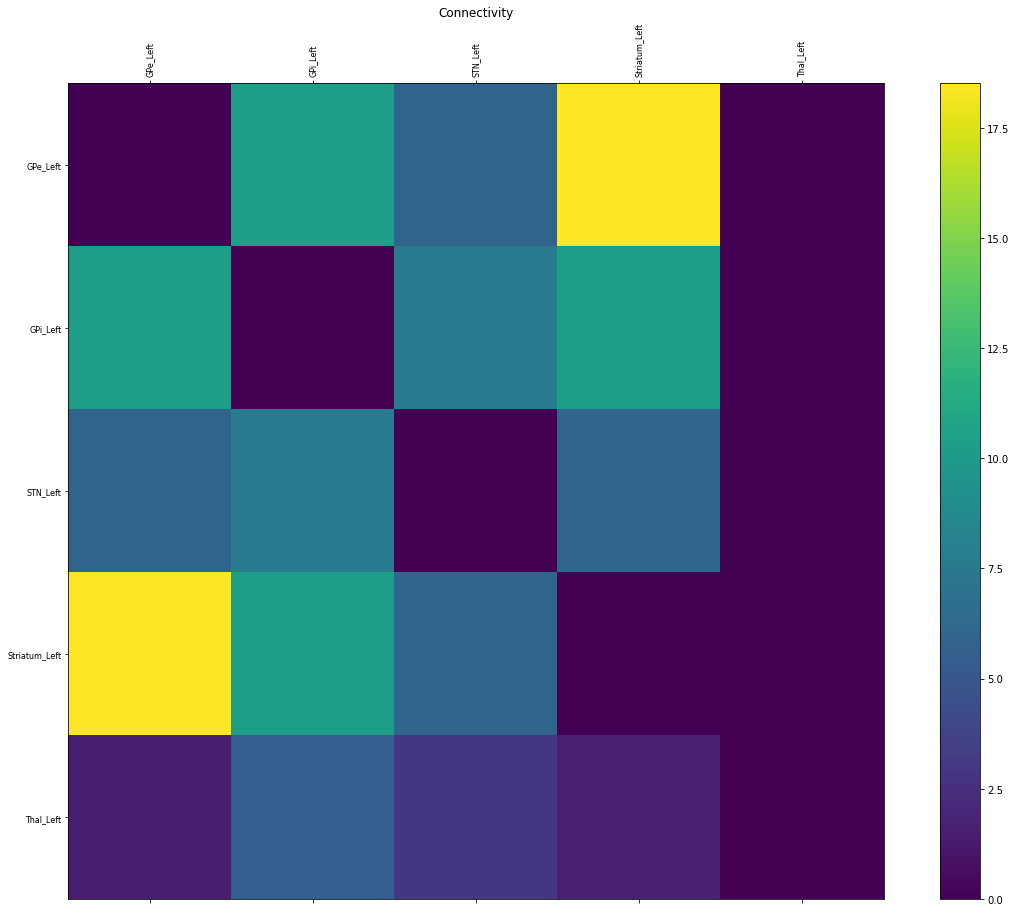

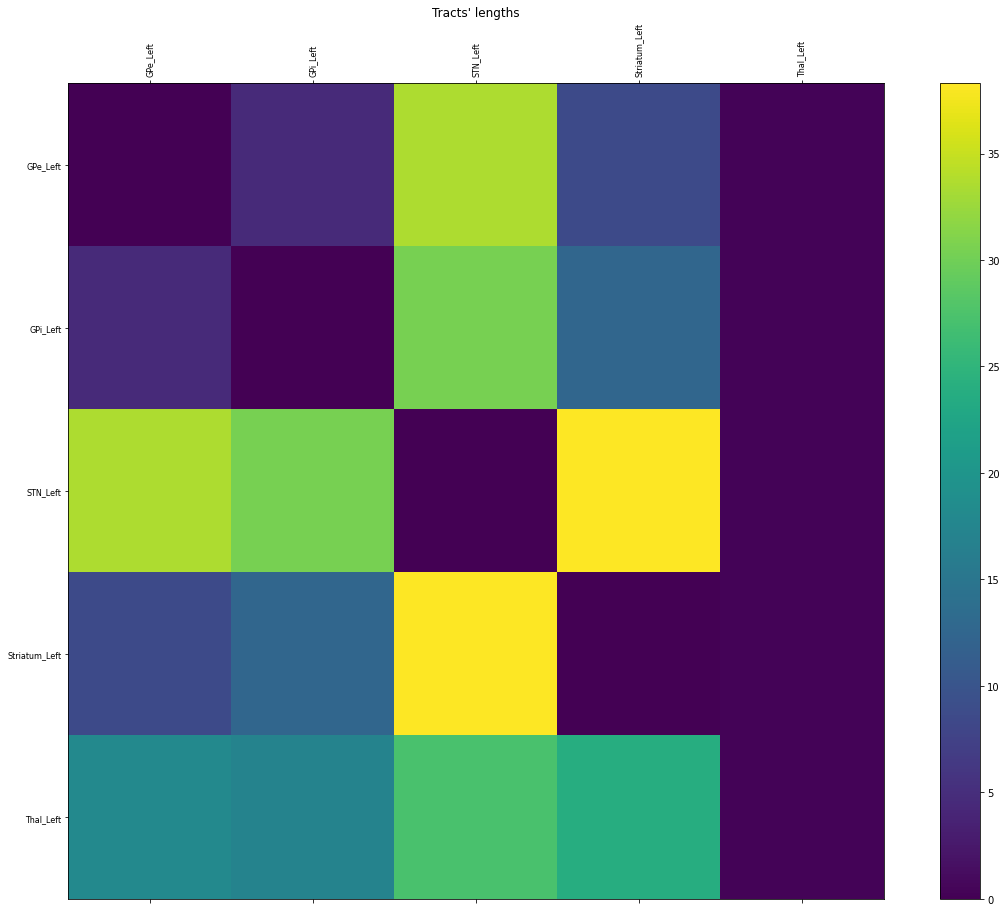

In [4]:
sliceBGnet = slice(0,5)
connTVBleftBG = Connectivity(region_labels=connLeft.region_labels[sliceBGnet], 
                             centres=connLeft.centres[sliceBGnet],
                             weights=connLeft.weights[sliceBGnet][:, sliceBGnet],
                             tract_lengths=connLeft.tract_lengths[sliceBGnet][:, sliceBGnet], 
                            speed=connLeft.speed)
connTVBleftBG.configure()

print("\nLeft BG TVB network:")
plotter.plot_tvb_connectivity(connTVBleftBG);


In [5]:
scaleBGoptTOtvb = np.percentile(BG_opt_matrix_weights, 95) /\
                  np.percentile(connTVBleftBG.weights, 95)
                  
print("Scaling factor of TVB BG network connectome to optimal one = %g" % scaleBGoptTOtvb)


Scaling factor of TVB BG network connectome to optimal one = 0.000709492



Left BG optimized network:


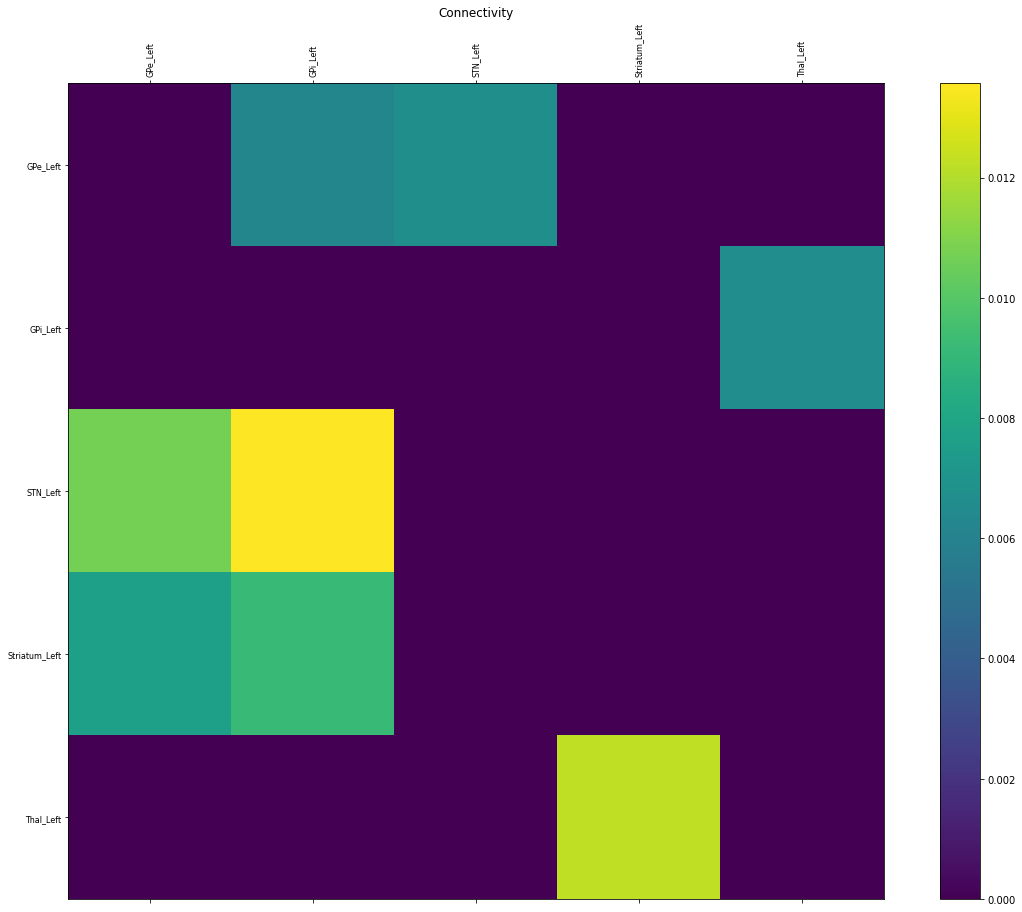

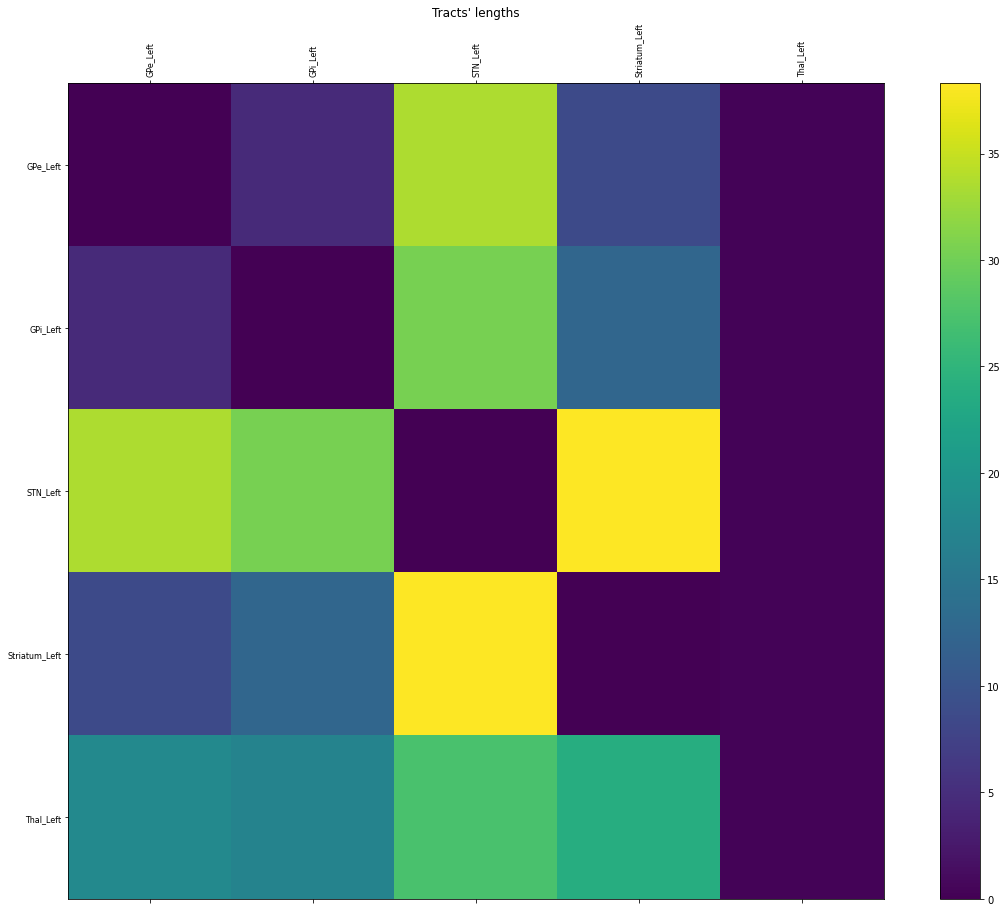

In [6]:
# Construct the final connectivity to use for simulation:
ww = scaleBGoptTOtvb * np.array(connLeft.weights)
ww[sliceBGnet, sliceBGnet] = BG_opt_matrix_weights

connectivity = Connectivity(region_labels=connLeft.region_labels, 
                            centres=connLeft.centres,
                            weights=ww, tract_lengths=connLeft.tract_lengths, 
                            speed=connLeft.speed)
connectivity.configure()

# Construct only the optimized BG connectivity only for plotting:
connBGopt = Connectivity(region_labels=connectivity.region_labels[sliceBGnet], 
                         centres=connectivity.centres[sliceBGnet],
                         weights=connectivity.weights[sliceBGnet][:, sliceBGnet],
                         tract_lengths=connectivity.tract_lengths[sliceBGnet][:, sliceBGnet], 
                         speed=connectivity.speed)
connBGopt.configure()

print("\nLeft BG optimized network:")
plotter.plot_tvb_connectivity(connBGopt);



Connectome used for simulations:


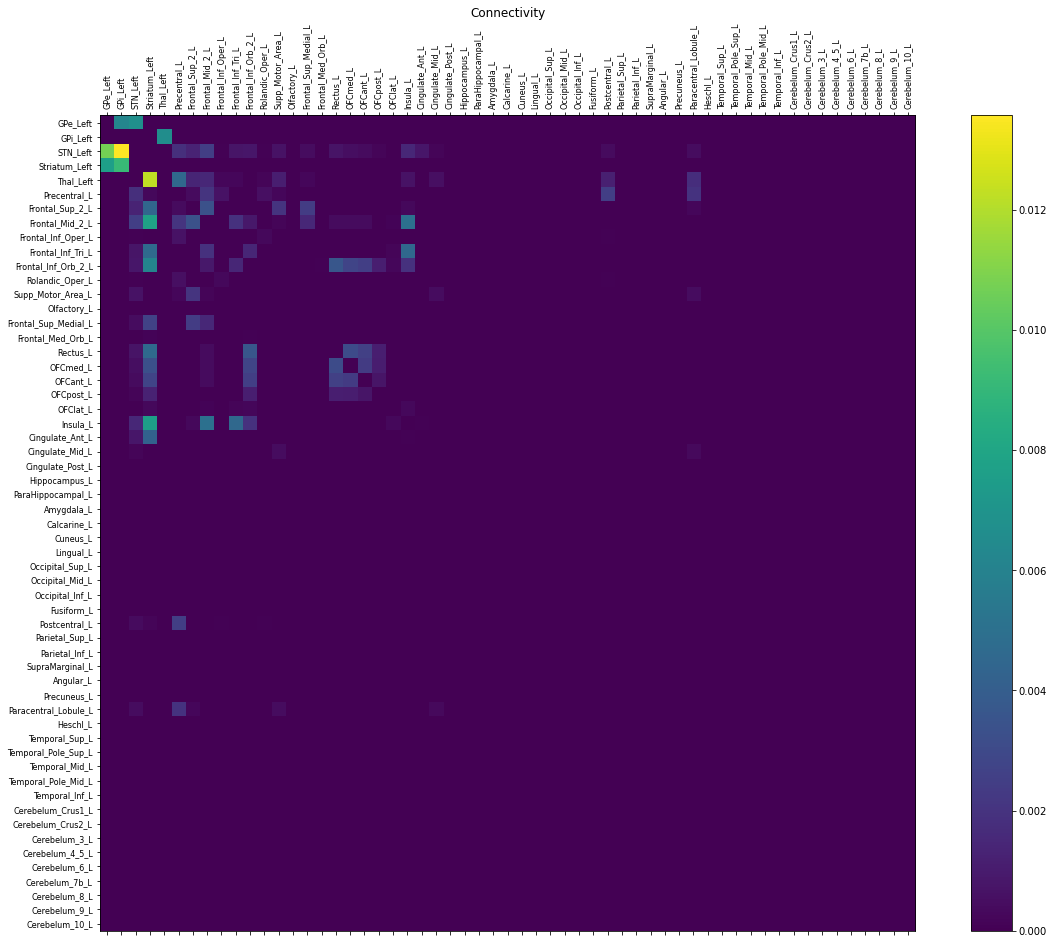

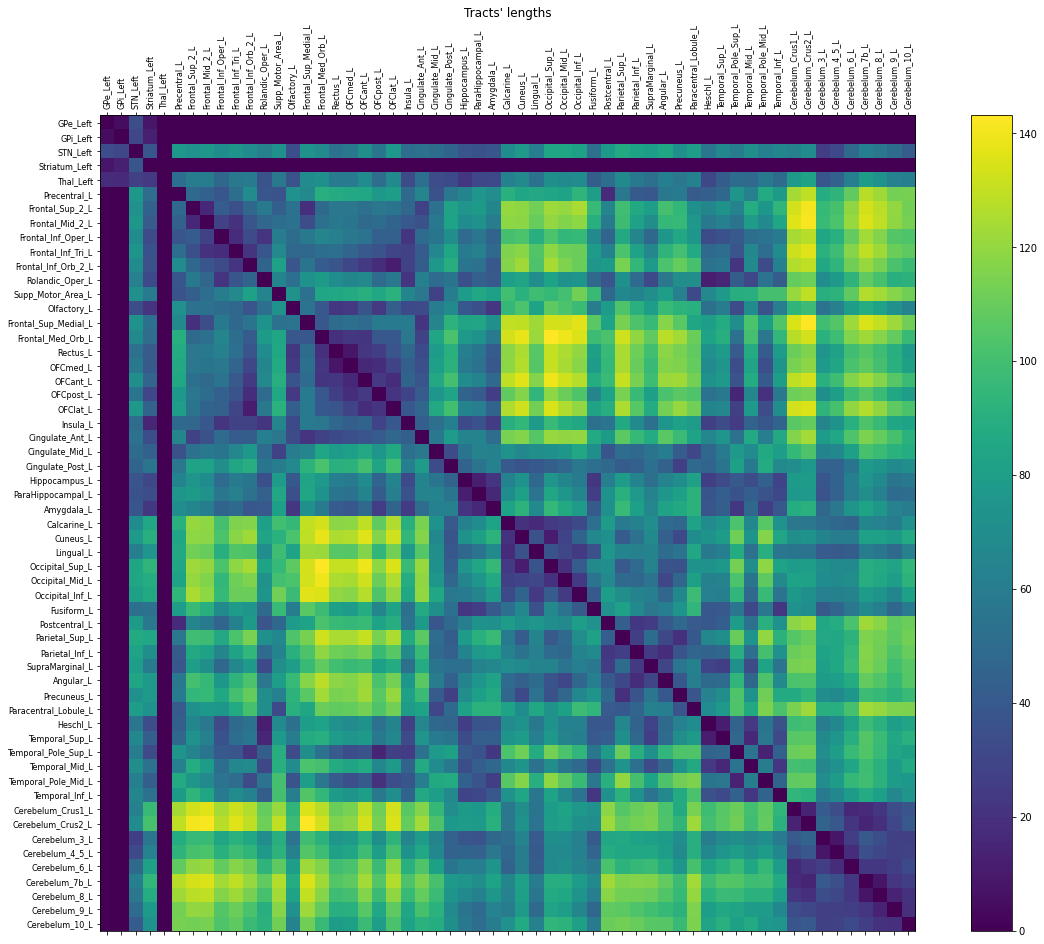

In [7]:
#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {"G": np.array([15.0/scaleBGoptTOtvb])}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([1e-5])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.connectivity.set_idelays(simulator.integrator.dt)
simulator.horizon = simulator.connectivity.idelays.max() + 1

init_cond_filepath = os.path.join(outputs_path, "tvb_init_cond_left.npy")
init_cond = np.load(init_cond_filepath)   # 
simulator.initial_conditions = init_cond * np.ones((simulator.horizon,
                                                    simulator.model.nvar,
                                                    simulator.connectivity.number_of_regions,
                                                    simulator.model.number_of_modes))


print("\nConnectome used for simulations:")
plotter.plot_tvb_connectivity(simulator.connectivity);


## 2. Build and connect the ANNarchy network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [8]:
from tvb_multiscale.tvb_annarchy.annarchy_models.builders.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder
from tvb_multiscale.tvb_annarchy.annarchy.models import Izhikevich_Hamker

# Select the regions for the fine scale modeling with ANNarchy spiking networks
#including cortex node:
spiking_nodes_ids = [0, 1, 2, 3, 4]  # the indices of fine scale regions modeled with ANNarchy

# Build a ANNarchy network model with the corresponding builder
ann_model_builder = BasalGangliaIzhikevichBuilder(simulator, spiking_nodes_ids, config=config, set_defaults=False)



# Using all default parameters for this example
# ann_model_builder.set_defaults()

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = Izhikevich_Hamker

ann_model_builder.population_order = 200 # reduce for speed

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

ann_model_builder.params_common = \
    {"v": -70.0, "u": -18.55, "E_ampa": 0.0, "E_gaba": -90.0, "v_th": 30.0, "Vr": 0.0, "c": -65.0,
     "C": 1.0, "I": 0.0,
     "tau_syn": 1.0, "tau_ampa": 10.0, "tau_gaba": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

ann_model_builder._paramsI = deepcopy(ann_model_builder.params_common)
ann_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
ann_model_builder._paramsE = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr.update({"v_th": 40.0, "C": 50.0, "Vr": -80.0,
                                    "n0": 61.65, "n1": 2.59, "n2": 0.02, 
                                    "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

ann_model_builder.Igpe_nodes_ids = [0]
ann_model_builder.Igpi_nodes_ids = [1]
ann_model_builder.Estn_nodes_ids = [2]
ann_model_builder.Eth_nodes_ids = [4]
ann_model_builder.Istr_nodes_ids = [3]


I_nodes_ids = ann_model_builder.Igpe_nodes_ids + ann_model_builder.Igpi_nodes_ids
E_nodes_ids = ann_model_builder.Estn_nodes_ids + ann_model_builder.Eth_nodes_ids


def paramsE_fun(node_id):
    paramsE = deepcopy(ann_model_builder._paramsE)
    if node_id in ann_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I": 3.0})  # dictionary of params for Estn
    elif node_id in ann_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I": 3.5})   # dictionary of params for Eth
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(ann_model_builder._paramsI)
    if node_id in ann_model_builder.Igpe_nodes_ids:
        paramsI.update({"I": 12.0})
    elif node_id in ann_model_builder.Igpi_nodes_ids:
        paramsI.update({"I": 30.0})
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
ann_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4]
     "scale": 1.0},
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1]
     "scale": 1.0},
    {"label": "IdSN", "model": population_neuron_model,   
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]

# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
ann_model_builder.global_coupling_scaling = 1.0 # ann_model_builder.coupling_a 
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
# ann_model_builder.global_coupling_scaling *= ann_model_builder.G

synapse_model = "DefaultSpikingSynapse"
conn_spec = {'rule': "all_to_all", 
             "allow_self_connections": True, "force_multiple_weights": False}
conn_spec_fixed_probability = conn_spec.copy()
conn_spec_fixed_probability.update({'rule': "fixed_probability", "probability": 0.1})

def conn_spec_fixed_prob(prob=None):
    output = conn_spec_fixed_probability.copy()
    if prob is not None:
        output["probability"] = prob
    return output

within_node_delay = 1.0
        

# for each connection, we have a different probability
ann_model_builder.populations_connections = [
     #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPe),  # conn_spec
     "weight": np.abs(wGPeGPe), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiGPi),  # conn_spec
     "weight": np.abs(wGPiGPi), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNdSN),  # conn_spec
     "weight": np.abs(wdSNdSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNiSN),  # conn_spec
     "weight": np.abs(wiSNiSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids}
    ]


# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay
        
class TVBWeightFun(object):
    tvb_weights = ann_model_builder.tvb_weights
    global_coupling_scaling = ann_model_builder.global_coupling_scaling
    
    def __init__(self, scale=ann_model_builder.global_coupling_scaling):
        self.tvb_weights = ann_model_builder.tvb_weights
        self.global_coupling_scaling = scale
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(ann_model_builder.tvb_dt, tvb_delay(source_node, target_node, ann_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
ann_model_builder.nodes_connections = [
    #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiTh),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpi_nodes_ids, 
     "target_nodes": ann_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeSTN),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThdSN),  # conn_spec
     "weight": TVBWeightFun(), # wThdSN, # 
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThiSN),  # conn_spec
     "weight": wThiSN,
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # No
     {"source": "E", "target": "I",          # "Estn" -> ["Igpe"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},
    {"source": "E", "target": "I",          # "Estn" -> ["Igpi"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids}
     ]

# Creating  devices to be able to observe ANNarchy activity:

ann_model_builder.output_devices = []

period = 1.0

# Creating  devices to be able to observe ANNarchy activity:
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["SpikeMonitor"])
params["period"] = period
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #                      label <- target population
    params["label"] = pop["label"] + "_spikes"
    connections[params["label"]] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "SpikeMonitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different for every connection to every distinct population
# params for baladron implementation commented out for the moment
# TODO: use baladron neurons
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["Monitor"])
params.update({"period": period,  'record_from': ["v", "u", "I_syn", "I_syn_ex", "I_syn_in", "g_ampa", "g_gaba", "g_base"]})
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #               label    <- target population
    connections[pop["label"]] = pop["label"]
    params["label"] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "Monitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    
    
# # Create a spike stimulus input device
# # including cortex node: we do not need any other external stimulation
# ann_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# ann_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# ann_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}
ann_model_builder.input_devices = [
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Estn_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[0]["scale"](ann_model_builder.Estn_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineEstn"},
#              "connections": {"BaselineEstn": ["E"]},  # "Estn"
#              "nodes": ann_model_builder.Estn_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpe_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpe_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpe"},
#              "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#              "nodes": ann_model_builder.Igpe_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpi_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpi_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpi"},
#              "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#              "nodes": ann_model_builder.Igpi_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
       ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


annarchy_network = ann_model_builder.build_spiking_network()


ANNarchy 4.6 (4.6.9.9) on linux (posix). 
2021-03-10 19:03:40,694 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2021-03-10 19:03:40,694 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2021-03-10 19:03:40,702 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2021-03-10 19:03:40,702 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2021-03-10 19:03:42,178 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for E_spikes created!
2021-03-10 19:03:42,178 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for E_spikes created!
2021-03-10 19:03:42,199 - INFO - tvb_multiscale.co

In [9]:
populations_sizes = []
print("Population sizes: ")
for pop in ann_model_builder.populations:
    populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
    print("%s: %d" % (pop["label"], populations_sizes[-1]))
    

Population sizes: 
E: 200
I: 200
IdSN: 200
IiSN: 200


In [10]:
# print(nest_network.print_str(connectivity=True))

## 3. Build the TVB-ANNarchy interface

In [11]:
from tvb_multiscale.tvb_annarchy.interfaces.builders.models.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

    
# Build a TVB-ANNarchy interface with all the appropriate connections between the
# TVB and ANNarchy modelled regions
tvb_annarchy_builder = \
    RedWWexcIOBuilder(simulator, annarchy_network, spiking_nodes_ids, 
                      exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_annarchy_mode = "rate"
annarchy_to_tvb = True

# Using all default parameters for this example

# or...


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------


# TVB -> ANNarchy


# --------For spike transmission from TVB to ANNarchy devices acting as TVB proxy nodes with TVB delays:--------

# tvb_annarchy_builder.G = tvb_annarchy_builder.tvb_simulator.model.G[0].item()
# tvb_annarchy_builder.global_coupling_scaling = tvb_annarchy_builder.tvb_simulator.coupling.a[0].item() * tvb_annarchy_builder.G
tvb_annarchy_builder.global_coupling_scaling = 0.3

class TVBWeightFun(object):
    tvb_weights = ann_model_builder.tvb_weights
    global_coupling_scaling = tvb_annarchy_builder.global_coupling_scaling
    
    def __init__(self, scale=tvb_annarchy_builder.global_coupling_scaling):
        self.tvb_weights = ann_model_builder.tvb_weights
        self.global_coupling_scaling = scale
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(tvb_annarchy_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_annarchy_builder.tvb_delays))

# Total TVB weight to STN:
wTVBSTNs = simulator.connectivity.weights[5:, ann_model_builder.Estn_nodes_ids].squeeze()
wTVBSTN = wTVBSTNs.sum()
print("wTVBSTN = %g" % wTVBSTN)
# Total TVB weight to Striatum:
wTVBSNs = simulator.connectivity.weights[5:, ann_model_builder.Istr_nodes_ids].squeeze()
wTVBSN = wTVBSNs.sum()
print("wTVBSN = %g" % wTVBSN)

iwCtxSTN = wCtxSTN / wTVBSTN
print("iwCtxSTN = %g" % iwCtxSTN)
print("wCtxSTN_effective = iwCtxSTN * wTVBSTN = %g = wCtxSTN = %g" % (iwCtxSTN * wTVBSTN, wCtxSTN))
# It has to be:
# # wCtxSTN / wCtxdSN = (iwCtxSTN * wTVBSTN) / (iwCtxdSN * wTVBSN) => (solving for iwCtxiSN)
# iwCtxdSN = wCtxdSN * iwCtxSTN * wTVBSTN / (wCtxSTN * wTVBSN) / 100 # interface weight for dSN
iwCtxdSN = 1.25*wCtxdSN / wTVBSN  # 1.25
print("iwCtxdSN = %g" % iwCtxdSN)
print("wCtxdSN_effective = iwCtxdSN * wTVBSN = %g = wCtxdSN = %g" % (iwCtxdSN * wTVBSN, wCtxdSN))
# # wCtxSTN / wCtxiSN = (iwCtxSTN * wTVBSTN) / (iwCtxiSN * wTVBSN) => (solving for iwCtxiSN)
# iwCtxiSN = wCtxiSN * iwCtxSTN * wTVBSTN / (wCtxSTN * wTVBSN) / 100 # interface weight for iSN
iwCtxiSN = 2*wCtxiSN / wTVBSN  # 2.0
print("iwCtxiSN = %g" % iwCtxiSN)
print("wCtxiSN_effective = iwCtxiSN * wTVBSN = %g = wCtxiSN = %g" % (iwCtxiSN * wTVBSN, wCtxiSN))

tvb_annarchy_builder.tvb_to_spikeNet_interfaces = []
if tvb_to_annarchy_mode == "rate":
    # Mean spike rates are applied in parallel to all target neurons
    for trg_pop, target_nodes, conn_scaling, this_conn_spec in zip(["E", "IdSN", "IiSN"],
                                                     [ann_model_builder.Estn_nodes_ids, 
                                                      ann_model_builder.Istr_nodes_ids, 
                                                      ann_model_builder.Istr_nodes_ids], 
                                                     [iwCtxSTN, iwCtxdSN, iwCtxiSN], # [wCtxSTN/52, wCtxdSN/52, wCtxiSN/52],
                                                     [conn_spec_fixed_prob(prob=pCtxSTN), # pCtxSTN  
                                                      conn_spec_fixed_prob(prob=pCtxdSN), # pCtxdSN
                                                      conn_spec_fixed_prob(prob=pCtxiSN)  # pCtxiSN
                                                      ]):          
        tvb_annarchy_builder.tvb_to_spikeNet_interfaces.append(
            {"model": "PoissonPopulation", "params": {"geometry": 600, "record": ["spike"]}, # TimedArray
        # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
             "interface_weights": 1.0,
        # Applied outside ANNarchy for each interface device
        # -------Properties potentially set as function handles with args (tvb_node_id=None, annarchy_node_id=None)-----------
             "weights": TVBWeightFun(scale=conn_scaling*tvb_annarchy_builder.global_coupling_scaling),
             "delays": lambda tvb_node_id, annarchy_node_id: tvb_delay_fun(tvb_node_id, annarchy_node_id),
             "receptor_type": "ampa",
             "conn_spec": this_conn_spec,
        # --------------------------------------------------------------------------------------------------------------
        #             TVB sv -> ANNarchy population
             "connections": {"R": trg_pop},
             "source_nodes": None, "target_nodes": target_nodes})  # None means all here

    
if annarchy_to_tvb:
    tvb_annarchy_builder.spikeNet_to_tvb_interfaces = []
    # TVB <-- ANNarchy:
    for src_pop, nodes in zip(["I",         "E",         ["IdSN", "IiSN"]],
                              [I_nodes_ids, E_nodes_ids, ann_model_builder.Istr_nodes_ids]):
        #            TVB <- ANNarchy
        tvb_annarchy_builder.spikeNet_to_tvb_interfaces.append(
            {"model": "SpikeMonitor", "params": {},
        # ------------------Properties potentially set as function handles with args (annarchy_node_id=None)--------------------
             "interface_weights": 1.0, "delays": 0.0,
        # -----------------------------------------------------------------------------------------------------------------                 #            TVB <- ANNarchy
        #                    TVB <- ANNarchy
             "connections": {"Rin": src_pop}, "nodes": nodes})  # None means all here
    
tvb_annarchy_builder.w_tvb_to_spike_rate = 1.0
# We return from a ANNarchy SpikeMonitor the ratio number_of_population_spikes / number_of_population_neurons
# for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# as long as a neuron cannot fire twice during a TVB time step, i.e.,
# as long as the TVB time step (usually 0.001 to 0.1 ms)
# is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
tvb_annarchy_builder.w_spikes_to_tvb = 1000.0

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

tvb_annarchy_model = tvb_annarchy_builder.build_interface(tvb_to_annarchy_mode=tvb_to_annarchy_mode, annarchy_to_tvb=annarchy_to_tvb)


wTVBSTN = 0.0138205
wTVBSN = 0.0506763
iwCtxSTN = 0.928525
wCtxSTN_effective = iwCtxSTN * wTVBSTN = 0.0128327 = wCtxSTN = 0.0128327
iwCtxdSN = 0.242744
wCtxdSN_effective = iwCtxdSN * wTVBSN = 0.0123014 = wCtxdSN = 0.0098411
iwCtxiSN = 0.421142
wCtxiSN_effective = iwCtxiSN * wTVBSN = 0.0213419 = wCtxiSN = 0.010671
2021-03-10 19:03:44,361 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-10 19:03:44,361 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-10 19:03:44,367 - INFO - tvb_multiscale.tvb_annarchy.interfaces.models - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-10 19:03:44,367 - INFO - tvb_multiscale.tvb_annarchy.interfaces.models - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-03-10 19:03:44,389 - INFO - tvb_multiscale.core.spiking_models.devices -

In [12]:
# print(np.corrcoef(1000*np.array([simulator.connectivity.weights[5:, ann_model_builder.Estn_nodes_ids], 
#                       simulator.connectivity.weights[5:, ann_model_builder.Istr_nodes_ids]]).squeeze()))
# source_nodes_STN = np.where(simulator.connectivity.weights[5:, ann_model_builder.Estn_nodes_ids].squeeze() > 0.0)[0] + 5
# print(source_nodes_STN)
# source_nodes_SN = np.where(simulator.connectivity.weights[5:, ann_model_builder.Istr_nodes_ids].squeeze() > 0.0)[0] + 5
# print(source_nodes_SN)
# conns = np.array([simulator.connectivity.weights[source_nodes_STN, ann_model_builder.Estn_nodes_ids],
#                   simulator.connectivity.weights[source_nodes_STN, ann_model_builder.Istr_nodes_ids]]).T
# print(1000 * conns)
# print(np.corrcoef(conns.T))

## 3. Configure simulator, simulate, gather results

In [13]:
# -----------------------------------4. Compile network ---------------------------------------------------------
# Compile the ANNarchy network...
tic_compile = time.time()
annarchy_network.configure()
print("Compiled! in %f min" % ((time.time() - tic_compile) / 60))
print(annarchy_network.print_str(connectivity=True))
print(tvb_annarchy_model.print_str(detailed_output=True, connectivity=False))


Compiled! in 0.093682 min

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
ANNarchyNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['GPe_Left', 'GPi_Left', 'STN_Left', 'Striatum_Left', 'Thal_Left']
Regions' nodes:


----------------------------------------------------------------------------------------------------
ANNarchyRegionNode - Label: GPe_Left
Populations ['I']:

----------------------------------------------------------------------------------------------------

ANNarchyPopulation - Label: I 
model: Spiking neuron
200 neurons in population with index: 0
parameters: {'a': array([0.005]), 'b': array([0.585]), 'c': array([-65.]), 'd': array(

In [14]:
 # -----------------------------------5. Simulate and gather results-------------------------------------------------
simulation_length = 550.0
transient = 150.0 # simulation_length/11
# ...and simulate!
t_start = time.time()
simulator.configure(tvb_annarchy_model) # 

if simulation_mode == "rs":
    simulation_length1 = simulation_length
else:
    simulation_length1 = 200.0
    
results = simulator.run(simulation_length=simulation_length1, # 35.0 with stimulus application
                        configure_spiking_simulator=False)    # because compilation has already be done

if simulation_mode != "rs":
    # for stimulus application:
    if simulation_mode.find("STN") > -1:
        Istim = -5.0 
        region = "STN_Left" 
        pop = "E" 
    else:
        Istim = -25.0 
        region = "GPi_Left" 
        pop = "I" 
    annarchy_network.brain_regions[region][pop].Set(
        {"I": Istim + annarchy_network.brain_regions[region][pop].Get("I")["I"]})
    results2 = simulator.run(simulation_length=250.0, 
                             configure_spiking_simulator=False)  # because compilation has already be done
    annarchy_network.brain_regions[region][pop].Set(
        {"I": annarchy_network.brain_regions[region][pop].Get("I")["I"] - Istim})
    results3 = simulator.run(simulation_length=100.0, 
                             configure_spiking_simulator=False)  # because compilation has already be done
    results[0] = list(results[0])
    results[0][0] = np.concatenate([results[0][0], results2[0][0], results3[0][0]], axis=0)
    results[0][1] = np.concatenate([results[0][1], results2[0][1], results3[0][1]], axis=0)

print("\nSimulated in %f secs!" % (time.time() - t_start))

Simulating 0.0001 seconds of the network took 0.002148151397705078 seconds. 
Simulating 0.0001 seconds of the network took 0.0033571720123291016 seconds. 
Simulating 0.0001 seconds of the network took 0.0028922557830810547 seconds. 
Simulating 0.0001 seconds of the network took 0.0029265880584716797 seconds. 
Simulating 0.0001 seconds of the network took 0.0016522407531738281 seconds. 
Simulating 0.0001 seconds of the network took 0.0016167163848876953 seconds. 
Simulating 0.0001 seconds of the network took 0.0018091201782226562 seconds. 
Simulating 0.0001 seconds of the network took 0.002033710479736328 seconds. 
Simulating 0.0001 seconds of the network took 0.00160980224609375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016651153564453125 seconds. 
Simulating 0.0001 seconds of the network took 0.007908105850219727 seconds. 
Simulating 0.0001 seconds of the network took 0.0018393993377685547 seconds. 
Simulating 0.0001 seconds of the network took 0.0025625228881835938 s

Simulating 0.0001 seconds of the network took 0.0015707015991210938 seconds. 
Simulating 0.0001 seconds of the network took 0.0018146038055419922 seconds. 
Simulating 0.0001 seconds of the network took 0.002197265625 seconds. 
Simulating 0.0001 seconds of the network took 0.0016307830810546875 seconds. 
Simulating 0.0001 seconds of the network took 0.0015716552734375 seconds. 
Simulating 0.0001 seconds of the network took 0.001611471176147461 seconds. 
Simulating 0.0001 seconds of the network took 0.0016772747039794922 seconds. 
Simulating 0.0001 seconds of the network took 0.0015997886657714844 seconds. 
Simulating 0.0001 seconds of the network took 0.00162506103515625 seconds. 
Simulating 0.0001 seconds of the network took 0.001598358154296875 seconds. 
Simulating 0.0001 seconds of the network took 0.001584768295288086 seconds. 
Simulating 0.0001 seconds of the network took 0.001592397689819336 seconds. 
Simulating 0.0001 seconds of the network took 0.0016937255859375 seconds. 
Simul

Simulating 0.0001 seconds of the network took 0.0016231536865234375 seconds. 
Simulating 0.0001 seconds of the network took 0.0015938282012939453 seconds. 
Simulating 0.0001 seconds of the network took 0.0015804767608642578 seconds. 
Simulating 0.0001 seconds of the network took 0.0016176700592041016 seconds. 
Simulating 0.0001 seconds of the network took 0.001605987548828125 seconds. 
Simulating 0.0001 seconds of the network took 0.0016684532165527344 seconds. 
Simulating 0.0001 seconds of the network took 0.0017275810241699219 seconds. 
Simulating 0.0001 seconds of the network took 0.001669168472290039 seconds. 
Simulating 0.0001 seconds of the network took 0.0016438961029052734 seconds. 
Simulating 0.0001 seconds of the network took 0.001687765121459961 seconds. 
Simulating 0.0001 seconds of the network took 0.0016019344329833984 seconds. 
Simulating 0.0001 seconds of the network took 0.0015573501586914062 seconds. 
Simulating 0.0001 seconds of the network took 0.001682281494140625 

Simulating 0.0001 seconds of the network took 0.001941680908203125 seconds. 
Simulating 0.0001 seconds of the network took 0.0016679763793945312 seconds. 
Simulating 0.0001 seconds of the network took 0.0016484260559082031 seconds. 
Simulating 0.0001 seconds of the network took 0.002664804458618164 seconds. 
Simulating 0.0001 seconds of the network took 0.0016093254089355469 seconds. 
Simulating 0.0001 seconds of the network took 0.0020351409912109375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016338825225830078 seconds. 
Simulating 0.0001 seconds of the network took 0.0016982555389404297 seconds. 
Simulating 0.0001 seconds of the network took 0.0016086101531982422 seconds. 
Simulating 0.0001 seconds of the network took 0.0015857219696044922 seconds. 
Simulating 0.0001 seconds of the network took 0.0016398429870605469 seconds. 
Simulating 0.0001 seconds of the network took 0.0023963451385498047 seconds. 
Simulating 0.0001 seconds of the network took 0.001616239547729492

Simulating 0.0001 seconds of the network took 0.001987934112548828 seconds. 
Simulating 0.0001 seconds of the network took 0.0016155242919921875 seconds. 
Simulating 0.0001 seconds of the network took 0.00154876708984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0017290115356445312 seconds. 
Simulating 0.0001 seconds of the network took 0.0017273426055908203 seconds. 
Simulating 0.0001 seconds of the network took 0.0018916130065917969 seconds. 
Simulating 0.0001 seconds of the network took 0.0016658306121826172 seconds. 
Simulating 0.0001 seconds of the network took 0.0016319751739501953 seconds. 
Simulating 0.0001 seconds of the network took 0.0016231536865234375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016665458679199219 seconds. 
Simulating 0.0001 seconds of the network took 0.001911163330078125 seconds. 
Simulating 0.0001 seconds of the network took 0.0017054080963134766 seconds. 
Simulating 0.0001 seconds of the network took 0.0015990734100341797 

Simulating 0.0001 seconds of the network took 0.0016911029815673828 seconds. 
Simulating 0.0001 seconds of the network took 0.0016970634460449219 seconds. 
Simulating 0.0001 seconds of the network took 0.0015630722045898438 seconds. 
Simulating 0.0001 seconds of the network took 0.0015935897827148438 seconds. 
Simulating 0.0001 seconds of the network took 0.0015943050384521484 seconds. 
Simulating 0.0001 seconds of the network took 0.0017533302307128906 seconds. 
Simulating 0.0001 seconds of the network took 0.0016188621520996094 seconds. 
Simulating 0.0001 seconds of the network took 0.0016632080078125 seconds. 
Simulating 0.0001 seconds of the network took 0.0017323493957519531 seconds. 
Simulating 0.0001 seconds of the network took 0.0016162395477294922 seconds. 
Simulating 0.0001 seconds of the network took 0.001680135726928711 seconds. 
Simulating 0.0001 seconds of the network took 0.002003192901611328 seconds. 
Simulating 0.0001 seconds of the network took 0.0017867088317871094 s

Simulating 0.0001 seconds of the network took 0.0018839836120605469 seconds. 
Simulating 0.0001 seconds of the network took 0.001918792724609375 seconds. 
Simulating 0.0001 seconds of the network took 0.001644134521484375 seconds. 
Simulating 0.0001 seconds of the network took 0.001922607421875 seconds. 
Simulating 0.0001 seconds of the network took 0.001611948013305664 seconds. 
Simulating 0.0001 seconds of the network took 0.00189971923828125 seconds. 
Simulating 0.0001 seconds of the network took 0.001565694808959961 seconds. 
Simulating 0.0001 seconds of the network took 0.0015833377838134766 seconds. 
Simulating 0.0001 seconds of the network took 0.0015680789947509766 seconds. 
Simulating 0.0001 seconds of the network took 0.0015745162963867188 seconds. 
Simulating 0.0001 seconds of the network took 0.0018410682678222656 seconds. 
Simulating 0.0001 seconds of the network took 0.0015935897827148438 seconds. 
Simulating 0.0001 seconds of the network took 0.0016698837280273438 second

Simulating 0.0001 seconds of the network took 0.003179311752319336 seconds. 
Simulating 0.0001 seconds of the network took 0.0017848014831542969 seconds. 
Simulating 0.0001 seconds of the network took 0.0021200180053710938 seconds. 
Simulating 0.0001 seconds of the network took 0.00182342529296875 seconds. 
Simulating 0.0001 seconds of the network took 0.0015938282012939453 seconds. 
Simulating 0.0001 seconds of the network took 0.0019228458404541016 seconds. 
Simulating 0.0001 seconds of the network took 0.0016973018646240234 seconds. 
Simulating 0.0001 seconds of the network took 0.0018491744995117188 seconds. 
Simulating 0.0001 seconds of the network took 0.001657724380493164 seconds. 
Simulating 0.0001 seconds of the network took 0.001627206802368164 seconds. 
Simulating 0.0001 seconds of the network took 0.002621173858642578 seconds. 
Simulating 0.0001 seconds of the network took 0.0016050338745117188 seconds. 
Simulating 0.0001 seconds of the network took 0.0016865730285644531 se

Simulating 0.0001 seconds of the network took 0.001583099365234375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016336441040039062 seconds. 
Simulating 0.0001 seconds of the network took 0.0015735626220703125 seconds. 
Simulating 0.0001 seconds of the network took 0.0016100406646728516 seconds. 
Simulating 0.0001 seconds of the network took 0.0015985965728759766 seconds. 
Simulating 0.0001 seconds of the network took 0.0015788078308105469 seconds. 
Simulating 0.0001 seconds of the network took 0.0023670196533203125 seconds. 
Simulating 0.0001 seconds of the network took 0.0015482902526855469 seconds. 
Simulating 0.0001 seconds of the network took 0.0016927719116210938 seconds. 
Simulating 0.0001 seconds of the network took 0.0016698837280273438 seconds. 
Simulating 0.0001 seconds of the network took 0.0016252994537353516 seconds. 
Simulating 0.0001 seconds of the network took 0.001703023910522461 seconds. 
Simulating 0.0001 seconds of the network took 0.002361297607421875

Simulating 0.0001 seconds of the network took 0.0017199516296386719 seconds. 
Simulating 0.0001 seconds of the network took 0.002129793167114258 seconds. 
Simulating 0.0001 seconds of the network took 0.001688241958618164 seconds. 
Simulating 0.0001 seconds of the network took 0.0017743110656738281 seconds. 
Simulating 0.0001 seconds of the network took 0.001674652099609375 seconds. 
Simulating 0.0001 seconds of the network took 0.0017719268798828125 seconds. 
Simulating 0.0001 seconds of the network took 0.0024509429931640625 seconds. 
Simulating 0.0001 seconds of the network took 0.0016047954559326172 seconds. 
Simulating 0.0001 seconds of the network took 0.001538991928100586 seconds. 
Simulating 0.0001 seconds of the network took 0.0015375614166259766 seconds. 
Simulating 0.0001 seconds of the network took 0.0023844242095947266 seconds. 
Simulating 0.0001 seconds of the network took 0.001781463623046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0016849040985107422 s

Simulating 0.0001 seconds of the network took 0.0018579959869384766 seconds. 
Simulating 0.0001 seconds of the network took 0.001644134521484375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016214847564697266 seconds. 
Simulating 0.0001 seconds of the network took 0.0017409324645996094 seconds. 
Simulating 0.0001 seconds of the network took 0.0015680789947509766 seconds. 
Simulating 0.0001 seconds of the network took 0.0015301704406738281 seconds. 
Simulating 0.0001 seconds of the network took 0.0016987323760986328 seconds. 
Simulating 0.0001 seconds of the network took 0.0015454292297363281 seconds. 
Simulating 0.0001 seconds of the network took 0.0015609264373779297 seconds. 
Simulating 0.0001 seconds of the network took 0.0015912055969238281 seconds. 
Simulating 0.0001 seconds of the network took 0.0015571117401123047 seconds. 
Simulating 0.0001 seconds of the network took 0.0016825199127197266 seconds. 
Simulating 0.0001 seconds of the network took 0.00271439552307128

Simulating 0.0001 seconds of the network took 0.0016751289367675781 seconds. 
Simulating 0.0001 seconds of the network took 0.0016388893127441406 seconds. 
Simulating 0.0001 seconds of the network took 0.0016734600067138672 seconds. 
Simulating 0.0001 seconds of the network took 0.002427816390991211 seconds. 
Simulating 0.0001 seconds of the network took 0.006353616714477539 seconds. 
Simulating 0.0001 seconds of the network took 0.0030355453491210938 seconds. 
Simulating 0.0001 seconds of the network took 0.0027785301208496094 seconds. 
Simulating 0.0001 seconds of the network took 0.0049021244049072266 seconds. 
Simulating 0.0001 seconds of the network took 0.0020704269409179688 seconds. 
Simulating 0.0001 seconds of the network took 0.0019216537475585938 seconds. 
Simulating 0.0001 seconds of the network took 0.0019021034240722656 seconds. 
Simulating 0.0001 seconds of the network took 0.005876779556274414 seconds. 
Simulating 0.0001 seconds of the network took 0.0020127296447753906

Simulating 0.0001 seconds of the network took 0.0019125938415527344 seconds. 
Simulating 0.0001 seconds of the network took 0.0018725395202636719 seconds. 
Simulating 0.0001 seconds of the network took 0.0016143321990966797 seconds. 
Simulating 0.0001 seconds of the network took 0.0016078948974609375 seconds. 
Simulating 0.0001 seconds of the network took 0.0015535354614257812 seconds. 
Simulating 0.0001 seconds of the network took 0.0016016960144042969 seconds. 
Simulating 0.0001 seconds of the network took 0.0016734600067138672 seconds. 
Simulating 0.0001 seconds of the network took 0.0016837120056152344 seconds. 
Simulating 0.0001 seconds of the network took 0.0015780925750732422 seconds. 
Simulating 0.0001 seconds of the network took 0.0015454292297363281 seconds. 
Simulating 0.0001 seconds of the network took 0.0016520023345947266 seconds. 
Simulating 0.0001 seconds of the network took 0.0017361640930175781 seconds. 
Simulating 0.0001 seconds of the network took 0.0016140937805175

Simulating 0.0001 seconds of the network took 0.0017244815826416016 seconds. 
...70.0% done in 66.4 sec
Simulating 0.0001 seconds of the network took 0.0016713142395019531 seconds. 
Simulating 0.0001 seconds of the network took 0.0017237663269042969 seconds. 
Simulating 0.0001 seconds of the network took 0.0018475055694580078 seconds. 
Simulating 0.0001 seconds of the network took 0.0015993118286132812 seconds. 
Simulating 0.0001 seconds of the network took 0.0017490386962890625 seconds. 
Simulating 0.0001 seconds of the network took 0.001909017562866211 seconds. 
Simulating 0.0001 seconds of the network took 0.0017268657684326172 seconds. 
Simulating 0.0001 seconds of the network took 0.0016334056854248047 seconds. 
Simulating 0.0001 seconds of the network took 0.0016336441040039062 seconds. 
Simulating 0.0001 seconds of the network took 0.0018253326416015625 seconds. 
Simulating 0.0001 seconds of the network took 0.0017807483673095703 seconds. 
Simulating 0.0001 seconds of the networ

Simulating 0.0001 seconds of the network took 0.001664876937866211 seconds. 
Simulating 0.0001 seconds of the network took 0.0015869140625 seconds. 
Simulating 0.0001 seconds of the network took 0.0015554428100585938 seconds. 
Simulating 0.0001 seconds of the network took 0.001634836196899414 seconds. 
Simulating 0.0001 seconds of the network took 0.0016520023345947266 seconds. 
Simulating 0.0001 seconds of the network took 0.0016651153564453125 seconds. 
Simulating 0.0001 seconds of the network took 0.001552581787109375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016448497772216797 seconds. 
Simulating 0.0001 seconds of the network took 0.0039675235748291016 seconds. 
Simulating 0.0001 seconds of the network took 0.0017838478088378906 seconds. 
Simulating 0.0001 seconds of the network took 0.0017924308776855469 seconds. 
Simulating 0.0001 seconds of the network took 0.0016641616821289062 seconds. 
Simulating 0.0001 seconds of the network took 0.0016145706176757812 secon

Simulating 0.0001 seconds of the network took 0.0016906261444091797 seconds. 
Simulating 0.0001 seconds of the network took 0.0016293525695800781 seconds. 
Simulating 0.0001 seconds of the network took 0.0017180442810058594 seconds. 
Simulating 0.0001 seconds of the network took 0.0017011165618896484 seconds. 
Simulating 0.0001 seconds of the network took 0.0016236305236816406 seconds. 
Simulating 0.0001 seconds of the network took 0.0016012191772460938 seconds. 
Simulating 0.0001 seconds of the network took 0.003507852554321289 seconds. 
Simulating 0.0001 seconds of the network took 0.0016880035400390625 seconds. 
Simulating 0.0001 seconds of the network took 0.001605987548828125 seconds. 
Simulating 0.0001 seconds of the network took 0.0016438961029052734 seconds. 
Simulating 0.0001 seconds of the network took 0.0015730857849121094 seconds. 
Simulating 0.0001 seconds of the network took 0.0022034645080566406 seconds. 
Simulating 0.0001 seconds of the network took 0.001852750778198242

Simulating 0.0001 seconds of the network took 0.0017752647399902344 seconds. 
Simulating 0.0001 seconds of the network took 0.0015451908111572266 seconds. 
Simulating 0.0001 seconds of the network took 0.0015604496002197266 seconds. 
Simulating 0.0001 seconds of the network took 0.0015671253204345703 seconds. 
Simulating 0.0001 seconds of the network took 0.0015521049499511719 seconds. 
Simulating 0.0001 seconds of the network took 0.0016667842864990234 seconds. 
Simulating 0.0001 seconds of the network took 0.0019392967224121094 seconds. 
Simulating 0.0001 seconds of the network took 0.001664876937866211 seconds. 
Simulating 0.0001 seconds of the network took 0.0016467571258544922 seconds. 
Simulating 0.0001 seconds of the network took 0.0016379356384277344 seconds. 
Simulating 0.0001 seconds of the network took 0.0015683174133300781 seconds. 
Simulating 0.0001 seconds of the network took 0.0018715858459472656 seconds. 
Simulating 0.0001 seconds of the network took 0.0016326904296875 

Simulating 0.0001 seconds of the network took 0.001986265182495117 seconds. 
Simulating 0.0001 seconds of the network took 0.0016045570373535156 seconds. 
Simulating 0.0001 seconds of the network took 0.001806497573852539 seconds. 
Simulating 0.0001 seconds of the network took 0.0015704631805419922 seconds. 
Simulating 0.0001 seconds of the network took 0.001600027084350586 seconds. 
Simulating 0.0001 seconds of the network took 0.001592874526977539 seconds. 
Simulating 0.0001 seconds of the network took 0.001895904541015625 seconds. 
Simulating 0.0001 seconds of the network took 0.0017583370208740234 seconds. 
Simulating 0.0001 seconds of the network took 0.0016345977783203125 seconds. 
Simulating 0.0001 seconds of the network took 0.0015401840209960938 seconds. 
Simulating 0.0001 seconds of the network took 0.0015971660614013672 seconds. 
Simulating 0.0001 seconds of the network took 0.0015919208526611328 seconds. 
Simulating 0.0001 seconds of the network took 0.0016512870788574219 s

Simulating 0.0001 seconds of the network took 0.002017498016357422 seconds. 
Simulating 0.0001 seconds of the network took 0.0017690658569335938 seconds. 
Simulating 0.0001 seconds of the network took 0.001550436019897461 seconds. 
Simulating 0.0001 seconds of the network took 0.0016057491302490234 seconds. 
Simulating 0.0001 seconds of the network took 0.0015892982482910156 seconds. 
Simulating 0.0001 seconds of the network took 0.0019271373748779297 seconds. 
Simulating 0.0001 seconds of the network took 0.0016384124755859375 seconds. 
Simulating 0.0001 seconds of the network took 0.0015742778778076172 seconds. 
Simulating 0.0001 seconds of the network took 0.0019176006317138672 seconds. 
Simulating 0.0001 seconds of the network took 0.001646280288696289 seconds. 
Simulating 0.0001 seconds of the network took 0.0016281604766845703 seconds. 
Simulating 0.0001 seconds of the network took 0.0017614364624023438 seconds. 
Simulating 0.0001 seconds of the network took 0.001537322998046875 

Simulating 0.0001 seconds of the network took 0.0016932487487792969 seconds. 
Simulating 0.0001 seconds of the network took 0.0016057491302490234 seconds. 
Simulating 0.0001 seconds of the network took 0.001604318618774414 seconds. 
Simulating 0.0001 seconds of the network took 0.0016367435455322266 seconds. 
Simulating 0.0001 seconds of the network took 0.010773658752441406 seconds. 
Simulating 0.0001 seconds of the network took 0.001607656478881836 seconds. 
Simulating 0.0001 seconds of the network took 0.0015747547149658203 seconds. 
Simulating 0.0001 seconds of the network took 0.0016973018646240234 seconds. 
Simulating 0.0001 seconds of the network took 0.001615285873413086 seconds. 
Simulating 0.0001 seconds of the network took 0.002906322479248047 seconds. 
Simulating 0.0001 seconds of the network took 0.001566171646118164 seconds. 
Simulating 0.0001 seconds of the network took 0.0015513896942138672 seconds. 
Simulating 0.0001 seconds of the network took 0.001550436019897461 sec

Simulating 0.0001 seconds of the network took 0.0015423297882080078 seconds. 
Simulating 0.0001 seconds of the network took 0.001851797103881836 seconds. 
Simulating 0.0001 seconds of the network took 0.0016667842864990234 seconds. 
Simulating 0.0001 seconds of the network took 0.001678466796875 seconds. 
Simulating 0.0001 seconds of the network took 0.001644134521484375 seconds. 
Simulating 0.0001 seconds of the network took 0.001657247543334961 seconds. 
Simulating 0.0001 seconds of the network took 0.0017228126525878906 seconds. 
Simulating 0.0001 seconds of the network took 0.0016579627990722656 seconds. 
Simulating 0.0001 seconds of the network took 0.0016634464263916016 seconds. 
Simulating 0.0001 seconds of the network took 0.001558542251586914 seconds. 
Simulating 0.0001 seconds of the network took 0.0015895366668701172 seconds. 
Simulating 0.0001 seconds of the network took 0.001725912094116211 seconds. 
Simulating 0.0001 seconds of the network took 0.0018775463104248047 secon

Simulating 0.0001 seconds of the network took 0.0016362667083740234 seconds. 
Simulating 0.0001 seconds of the network took 0.001668691635131836 seconds. 
Simulating 0.0001 seconds of the network took 0.0016269683837890625 seconds. 
Simulating 0.0001 seconds of the network took 0.0016279220581054688 seconds. 
Simulating 0.0001 seconds of the network took 0.002936124801635742 seconds. 
Simulating 0.0001 seconds of the network took 0.002122163772583008 seconds. 
Simulating 0.0001 seconds of the network took 0.0016622543334960938 seconds. 
Simulating 0.0001 seconds of the network took 0.0016713142395019531 seconds. 
Simulating 0.0001 seconds of the network took 0.001874685287475586 seconds. 
Simulating 0.0001 seconds of the network took 0.0019507408142089844 seconds. 
Simulating 0.0001 seconds of the network took 0.001863718032836914 seconds. 
Simulating 0.0001 seconds of the network took 0.0023241043090820312 seconds. 
Simulating 0.0001 seconds of the network took 0.0017654895782470703 s

Simulating 0.0001 seconds of the network took 0.0018157958984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016562938690185547 seconds. 
Simulating 0.0001 seconds of the network took 0.0016169548034667969 seconds. 
Simulating 0.0001 seconds of the network took 0.0015881061553955078 seconds. 
Simulating 0.0001 seconds of the network took 0.0016319751739501953 seconds. 
Simulating 0.0001 seconds of the network took 0.001760721206665039 seconds. 
Simulating 0.0001 seconds of the network took 0.001638174057006836 seconds. 
Simulating 0.0001 seconds of the network took 0.0017201900482177734 seconds. 
Simulating 0.0001 seconds of the network took 0.0016720294952392578 seconds. 
Simulating 0.0001 seconds of the network took 0.0015912055969238281 seconds. 
Simulating 0.0001 seconds of the network took 0.001972675323486328 seconds. 
Simulating 0.0001 seconds of the network took 0.0015919208526611328 seconds. 
Simulating 0.0001 seconds of the network took 0.0016527175903320312 se

Simulating 0.0001 seconds of the network took 0.0018184185028076172 seconds. 
Simulating 0.0001 seconds of the network took 0.0016241073608398438 seconds. 
Simulating 0.0001 seconds of the network took 0.0016977787017822266 seconds. 
Simulating 0.0001 seconds of the network took 0.0017037391662597656 seconds. 
Simulating 0.0001 seconds of the network took 0.001720428466796875 seconds. 
Simulating 0.0001 seconds of the network took 0.0019154548645019531 seconds. 
Simulating 0.0001 seconds of the network took 0.0015971660614013672 seconds. 
Simulating 0.0001 seconds of the network took 0.0018010139465332031 seconds. 
Simulating 0.0001 seconds of the network took 0.0016202926635742188 seconds. 
Simulating 0.0001 seconds of the network took 0.0018074512481689453 seconds. 
Simulating 0.0001 seconds of the network took 0.0016660690307617188 seconds. 
Simulating 0.0001 seconds of the network took 0.0016372203826904297 seconds. 
Simulating 0.0001 seconds of the network took 0.00164651870727539

Simulating 0.0001 seconds of the network took 0.0018935203552246094 seconds. 
Simulating 0.0001 seconds of the network took 0.0016276836395263672 seconds. 
Simulating 0.0001 seconds of the network took 0.0016086101531982422 seconds. 
Simulating 0.0001 seconds of the network took 0.0017201900482177734 seconds. 
Simulating 0.0001 seconds of the network took 0.0015780925750732422 seconds. 
Simulating 0.0001 seconds of the network took 0.0017397403717041016 seconds. 
Simulating 0.0001 seconds of the network took 0.0017900466918945312 seconds. 
Simulating 0.0001 seconds of the network took 0.0015902519226074219 seconds. 
Simulating 0.0001 seconds of the network took 0.0016937255859375 seconds. 
Simulating 0.0001 seconds of the network took 0.0015823841094970703 seconds. 
Simulating 0.0001 seconds of the network took 0.0016880035400390625 seconds. 
Simulating 0.0001 seconds of the network took 0.001789093017578125 seconds. 
Simulating 0.0001 seconds of the network took 0.0016515254974365234 

Simulating 0.0001 seconds of the network took 0.0020372867584228516 seconds. 
Simulating 0.0001 seconds of the network took 0.001611948013305664 seconds. 
Simulating 0.0001 seconds of the network took 0.001636505126953125 seconds. 
Simulating 0.0001 seconds of the network took 0.0016057491302490234 seconds. 
Simulating 0.0001 seconds of the network took 0.0016057491302490234 seconds. 
Simulating 0.0001 seconds of the network took 0.0016565322875976562 seconds. 
Simulating 0.0001 seconds of the network took 0.0017936229705810547 seconds. 
Simulating 0.0001 seconds of the network took 0.001627206802368164 seconds. 
Simulating 0.0001 seconds of the network took 0.00168609619140625 seconds. 
Simulating 0.0001 seconds of the network took 0.001607656478881836 seconds. 
Simulating 0.0001 seconds of the network took 0.001664876937866211 seconds. 
Simulating 0.0001 seconds of the network took 0.001749277114868164 seconds. 
Simulating 0.0001 seconds of the network took 0.0017108917236328125 seco

Simulating 0.0001 seconds of the network took 0.0017981529235839844 seconds. 
Simulating 0.0001 seconds of the network took 0.0017366409301757812 seconds. 
Simulating 0.0001 seconds of the network took 0.0019800662994384766 seconds. 
Simulating 0.0001 seconds of the network took 0.0018010139465332031 seconds. 
Simulating 0.0001 seconds of the network took 0.001712799072265625 seconds. 
Simulating 0.0001 seconds of the network took 0.0016446113586425781 seconds. 
Simulating 0.0001 seconds of the network took 0.0017201900482177734 seconds. 
Simulating 0.0001 seconds of the network took 0.001622915267944336 seconds. 
Simulating 0.0001 seconds of the network took 0.0016744136810302734 seconds. 
Simulating 0.0001 seconds of the network took 0.0016603469848632812 seconds. 
Simulating 0.0001 seconds of the network took 0.0016446113586425781 seconds. 
Simulating 0.0001 seconds of the network took 0.0019183158874511719 seconds. 
Simulating 0.0001 seconds of the network took 0.001678705215454101

Simulating 0.0001 seconds of the network took 0.0017616748809814453 seconds. 
Simulating 0.0001 seconds of the network took 0.0016374588012695312 seconds. 
Simulating 0.0001 seconds of the network took 0.001682281494140625 seconds. 
Simulating 0.0001 seconds of the network took 0.001622915267944336 seconds. 
Simulating 0.0001 seconds of the network took 0.0018069744110107422 seconds. 
Simulating 0.0001 seconds of the network took 0.0015721321105957031 seconds. 
Simulating 0.0001 seconds of the network took 0.002481698989868164 seconds. 
Simulating 0.0001 seconds of the network took 0.0019731521606445312 seconds. 
Simulating 0.0001 seconds of the network took 0.0015950202941894531 seconds. 
Simulating 0.0001 seconds of the network took 0.0016210079193115234 seconds. 
Simulating 0.0001 seconds of the network took 0.0016121864318847656 seconds. 
Simulating 0.0001 seconds of the network took 0.001722097396850586 seconds. 
Simulating 0.0001 seconds of the network took 0.0016264915466308594 

Simulating 0.0001 seconds of the network took 0.0017588138580322266 seconds. 
Simulating 0.0001 seconds of the network took 0.0018925666809082031 seconds. 
Simulating 0.0001 seconds of the network took 0.0015721321105957031 seconds. 
Simulating 0.0001 seconds of the network took 0.0016188621520996094 seconds. 
Simulating 0.0001 seconds of the network took 0.0022339820861816406 seconds. 
Simulating 0.0001 seconds of the network took 0.001748800277709961 seconds. 
Simulating 0.0001 seconds of the network took 0.0016481876373291016 seconds. 
Simulating 0.0001 seconds of the network took 0.001802682876586914 seconds. 
Simulating 0.0001 seconds of the network took 0.0015392303466796875 seconds. 
Simulating 0.0001 seconds of the network took 0.001588582992553711 seconds. 
Simulating 0.0001 seconds of the network took 0.0015997886657714844 seconds. 
Simulating 0.0001 seconds of the network took 0.001840353012084961 seconds. 
Simulating 0.0001 seconds of the network took 0.0016887187957763672 

Simulating 0.0001 seconds of the network took 0.0017626285552978516 seconds. 
Simulating 0.0001 seconds of the network took 0.0017006397247314453 seconds. 
Simulating 0.0001 seconds of the network took 0.0016937255859375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016198158264160156 seconds. 
Simulating 0.0001 seconds of the network took 0.0015926361083984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0018346309661865234 seconds. 
Simulating 0.0001 seconds of the network took 0.0017061233520507812 seconds. 
Simulating 0.0001 seconds of the network took 0.0015785694122314453 seconds. 
Simulating 0.0001 seconds of the network took 0.0016028881072998047 seconds. 
Simulating 0.0001 seconds of the network took 0.0024733543395996094 seconds. 
Simulating 0.0001 seconds of the network took 0.0017459392547607422 seconds. 
Simulating 0.0001 seconds of the network took 0.0016131401062011719 seconds. 
Simulating 0.0001 seconds of the network took 0.0016007423400878906

Simulating 0.0001 seconds of the network took 0.0028176307678222656 seconds. 
Simulating 0.0001 seconds of the network took 0.0016977787017822266 seconds. 
Simulating 0.0001 seconds of the network took 0.0017921924591064453 seconds. 
Simulating 0.0001 seconds of the network took 0.0017702579498291016 seconds. 
Simulating 0.0001 seconds of the network took 0.0020608901977539062 seconds. 
Simulating 0.0001 seconds of the network took 0.0016028881072998047 seconds. 
Simulating 0.0001 seconds of the network took 0.0016193389892578125 seconds. 
Simulating 0.0001 seconds of the network took 0.0017147064208984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016226768493652344 seconds. 
Simulating 0.0001 seconds of the network took 0.0018229484558105469 seconds. 
Simulating 0.0001 seconds of the network took 0.0016660690307617188 seconds. 
Simulating 0.0001 seconds of the network took 0.0015635490417480469 seconds. 
Simulating 0.0001 seconds of the network took 0.0017042160034179

Simulating 0.0001 seconds of the network took 0.0016145706176757812 seconds. 
Simulating 0.0001 seconds of the network took 0.0018563270568847656 seconds. 
Simulating 0.0001 seconds of the network took 0.0016255378723144531 seconds. 
Simulating 0.0001 seconds of the network took 0.0017552375793457031 seconds. 
Simulating 0.0001 seconds of the network took 0.0017960071563720703 seconds. 
Simulating 0.0001 seconds of the network took 0.00185394287109375 seconds. 
Simulating 0.0001 seconds of the network took 0.003530740737915039 seconds. 
Simulating 0.0001 seconds of the network took 0.0022568702697753906 seconds. 
Simulating 0.0001 seconds of the network took 0.001569509506225586 seconds. 
Simulating 0.0001 seconds of the network took 0.0016562938690185547 seconds. 
Simulating 0.0001 seconds of the network took 0.0017852783203125 seconds. 
Simulating 0.0001 seconds of the network took 0.0016243457794189453 seconds. 
Simulating 0.0001 seconds of the network took 0.001689910888671875 seco

Simulating 0.0001 seconds of the network took 0.0022301673889160156 seconds. 
Simulating 0.0001 seconds of the network took 0.0017077922821044922 seconds. 
Simulating 0.0001 seconds of the network took 0.0016846656799316406 seconds. 
Simulating 0.0001 seconds of the network took 0.0016396045684814453 seconds. 
Simulating 0.0001 seconds of the network took 0.0016608238220214844 seconds. 
Simulating 0.0001 seconds of the network took 0.0017206668853759766 seconds. 
Simulating 0.0001 seconds of the network took 0.005358457565307617 seconds. 
Simulating 0.0001 seconds of the network took 0.0017845630645751953 seconds. 
Simulating 0.0001 seconds of the network took 0.0017631053924560547 seconds. 
Simulating 0.0001 seconds of the network took 0.0016295909881591797 seconds. 
Simulating 0.0001 seconds of the network took 0.0016427040100097656 seconds. 
Simulating 0.0001 seconds of the network took 0.001920938491821289 seconds. 
Simulating 0.0001 seconds of the network took 0.001611709594726562

Simulating 0.0001 seconds of the network took 0.0017554759979248047 seconds. 
Simulating 0.0001 seconds of the network took 0.0017654895782470703 seconds. 
Simulating 0.0001 seconds of the network took 0.0015919208526611328 seconds. 
Simulating 0.0001 seconds of the network took 0.00167083740234375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016283988952636719 seconds. 
Simulating 0.0001 seconds of the network took 0.0017287731170654297 seconds. 
Simulating 0.0001 seconds of the network took 0.0015947818756103516 seconds. 
Simulating 0.0001 seconds of the network took 0.001588582992553711 seconds. 
Simulating 0.0001 seconds of the network took 0.0016205310821533203 seconds. 
Simulating 0.0001 seconds of the network took 0.001621246337890625 seconds. 
Simulating 0.0001 seconds of the network took 0.0017523765563964844 seconds. 
Simulating 0.0001 seconds of the network took 0.0015680789947509766 seconds. 
Simulating 0.0001 seconds of the network took 0.0016169548034667969 

Simulating 0.0001 seconds of the network took 0.0017933845520019531 seconds. 
Simulating 0.0001 seconds of the network took 0.0016162395477294922 seconds. 
Simulating 0.0001 seconds of the network took 0.0019686222076416016 seconds. 
Simulating 0.0001 seconds of the network took 0.0016560554504394531 seconds. 
Simulating 0.0001 seconds of the network took 0.0016396045684814453 seconds. 
Simulating 0.0001 seconds of the network took 0.0017361640930175781 seconds. 
Simulating 0.0001 seconds of the network took 0.0017242431640625 seconds. 
Simulating 0.0001 seconds of the network took 0.0015711784362792969 seconds. 
Simulating 0.0001 seconds of the network took 0.0015721321105957031 seconds. 
Simulating 0.0001 seconds of the network took 0.0016856193542480469 seconds. 
Simulating 0.0001 seconds of the network took 0.0017473697662353516 seconds. 
Simulating 0.0001 seconds of the network took 0.002948760986328125 seconds. 
Simulating 0.0001 seconds of the network took 0.0018105506896972656 

Simulating 0.0001 seconds of the network took 0.0018665790557861328 seconds. 
Simulating 0.0001 seconds of the network took 0.0016732215881347656 seconds. 
Simulating 0.0001 seconds of the network took 0.0016894340515136719 seconds. 
Simulating 0.0001 seconds of the network took 0.0016791820526123047 seconds. 
Simulating 0.0001 seconds of the network took 0.0016946792602539062 seconds. 
Simulating 0.0001 seconds of the network took 0.0016589164733886719 seconds. 
Simulating 0.0001 seconds of the network took 0.0028488636016845703 seconds. 
Simulating 0.0001 seconds of the network took 0.0016603469848632812 seconds. 
Simulating 0.0001 seconds of the network took 0.0017054080963134766 seconds. 
Simulating 0.0001 seconds of the network took 0.0021376609802246094 seconds. 
Simulating 0.0001 seconds of the network took 0.0016491413116455078 seconds. 
Simulating 0.0001 seconds of the network took 0.0017888545989990234 seconds. 
Simulating 0.0001 seconds of the network took 0.0016798973083496

Simulating 0.0001 seconds of the network took 0.0016901493072509766 seconds. 
Simulating 0.0001 seconds of the network took 0.001552581787109375 seconds. 
Simulating 0.0001 seconds of the network took 0.001631021499633789 seconds. 
Simulating 0.0001 seconds of the network took 0.001592397689819336 seconds. 
Simulating 0.0001 seconds of the network took 0.0015711784362792969 seconds. 
Simulating 0.0001 seconds of the network took 0.001734018325805664 seconds. 
Simulating 0.0001 seconds of the network took 0.0015833377838134766 seconds. 
Simulating 0.0001 seconds of the network took 0.0024652481079101562 seconds. 
Simulating 0.0001 seconds of the network took 0.001672983169555664 seconds. 
Simulating 0.0001 seconds of the network took 0.001682281494140625 seconds. 
Simulating 0.0001 seconds of the network took 0.0016756057739257812 seconds. 
Simulating 0.0001 seconds of the network took 0.0016596317291259766 seconds. 
Simulating 0.0001 seconds of the network took 0.0016658306121826172 se

Simulating 0.0001 seconds of the network took 0.0018658638000488281 seconds. 
Simulating 0.0001 seconds of the network took 0.0015583038330078125 seconds. 
Simulating 0.0001 seconds of the network took 0.001573801040649414 seconds. 
Simulating 0.0001 seconds of the network took 0.001577615737915039 seconds. 
Simulating 0.0001 seconds of the network took 0.0016188621520996094 seconds. 
Simulating 0.0001 seconds of the network took 0.0015816688537597656 seconds. 
Simulating 0.0001 seconds of the network took 0.0019960403442382812 seconds. 
Simulating 0.0001 seconds of the network took 0.0016863346099853516 seconds. 
Simulating 0.0001 seconds of the network took 0.0016078948974609375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016183853149414062 seconds. 
Simulating 0.0001 seconds of the network took 0.0019066333770751953 seconds. 
Simulating 0.0001 seconds of the network took 0.0037131309509277344 seconds. 
Simulating 0.0001 seconds of the network took 0.001767158508300781

Simulating 0.0001 seconds of the network took 0.0029113292694091797 seconds. 
Simulating 0.0001 seconds of the network took 0.0017211437225341797 seconds. 
Simulating 0.0001 seconds of the network took 0.0016193389892578125 seconds. 
Simulating 0.0001 seconds of the network took 0.002054452896118164 seconds. 
Simulating 0.0001 seconds of the network took 0.0016283988952636719 seconds. 
Simulating 0.0001 seconds of the network took 0.001674652099609375 seconds. 
Simulating 0.0001 seconds of the network took 0.0017468929290771484 seconds. 
Simulating 0.0001 seconds of the network took 0.0016427040100097656 seconds. 
Simulating 0.0001 seconds of the network took 0.001588582992553711 seconds. 
Simulating 0.0001 seconds of the network took 0.0017285346984863281 seconds. 
Simulating 0.0001 seconds of the network took 0.0016100406646728516 seconds. 
Simulating 0.0001 seconds of the network took 0.0016350746154785156 seconds. 
Simulating 0.0001 seconds of the network took 0.0016086101531982422

Simulating 0.0001 seconds of the network took 0.002823352813720703 seconds. 
Simulating 0.0001 seconds of the network took 0.00171661376953125 seconds. 
Simulating 0.0001 seconds of the network took 0.0018703937530517578 seconds. 
Simulating 0.0001 seconds of the network took 0.0018093585968017578 seconds. 
Simulating 0.0001 seconds of the network took 0.0017361640930175781 seconds. 
Simulating 0.0001 seconds of the network took 0.0021643638610839844 seconds. 
Simulating 0.0001 seconds of the network took 0.0016794204711914062 seconds. 
Simulating 0.0001 seconds of the network took 0.0017938613891601562 seconds. 
Simulating 0.0001 seconds of the network took 0.0015933513641357422 seconds. 
Simulating 0.0001 seconds of the network took 0.002182483673095703 seconds. 
Simulating 0.0001 seconds of the network took 0.0016434192657470703 seconds. 
Simulating 0.0001 seconds of the network took 0.0017282962799072266 seconds. 
Simulating 0.0001 seconds of the network took 0.001924276351928711 s

Simulating 0.0001 seconds of the network took 0.0016739368438720703 seconds. 
Simulating 0.0001 seconds of the network took 0.0016143321990966797 seconds. 
Simulating 0.0001 seconds of the network took 0.0017197132110595703 seconds. 
Simulating 0.0001 seconds of the network took 0.0016207695007324219 seconds. 
Simulating 0.0001 seconds of the network took 0.0015652179718017578 seconds. 
Simulating 0.0001 seconds of the network took 0.002532958984375 seconds. 
Simulating 0.0001 seconds of the network took 0.0018961429595947266 seconds. 
Simulating 0.0001 seconds of the network took 0.0021352767944335938 seconds. 
Simulating 0.0001 seconds of the network took 0.0016167163848876953 seconds. 
Simulating 0.0001 seconds of the network took 0.0017902851104736328 seconds. 
Simulating 0.0001 seconds of the network took 0.0017502307891845703 seconds. 
Simulating 0.0001 seconds of the network took 0.001615762710571289 seconds. 
Simulating 0.0001 seconds of the network took 0.003406047821044922 se

Simulating 0.0001 seconds of the network took 0.0016117095947265625 seconds. 
Simulating 0.0001 seconds of the network took 0.0016851425170898438 seconds. 
Simulating 0.0001 seconds of the network took 0.001703023910522461 seconds. 
Simulating 0.0001 seconds of the network took 0.001730203628540039 seconds. 
Simulating 0.0001 seconds of the network took 0.001569509506225586 seconds. 
Simulating 0.0001 seconds of the network took 0.0016384124755859375 seconds. 
Simulating 0.0001 seconds of the network took 0.0016705989837646484 seconds. 
Simulating 0.0001 seconds of the network took 0.0016732215881347656 seconds. 
Simulating 0.0001 seconds of the network took 0.00164031982421875 seconds. 
Simulating 0.0001 seconds of the network took 0.0016815662384033203 seconds. 
Simulating 0.0001 seconds of the network took 0.0016813278198242188 seconds. 
Simulating 0.0001 seconds of the network took 0.0018343925476074219 seconds. 
Simulating 0.0001 seconds of the network took 0.0018951892852783203 s

Simulating 0.0001 seconds of the network took 0.00254058837890625 seconds. 
Simulating 0.0001 seconds of the network took 0.0017075538635253906 seconds. 
Simulating 0.0001 seconds of the network took 0.0015707015991210938 seconds. 
Simulating 0.0001 seconds of the network took 0.0015811920166015625 seconds. 
Simulating 0.0001 seconds of the network took 0.0015828609466552734 seconds. 
Simulating 0.0001 seconds of the network took 0.002106904983520508 seconds. 
Simulating 0.0001 seconds of the network took 0.001603841781616211 seconds. 
Simulating 0.0001 seconds of the network took 0.0015239715576171875 seconds. 
Simulating 0.0001 seconds of the network took 0.003844738006591797 seconds. 
Simulating 0.0001 seconds of the network took 0.0017156600952148438 seconds. 
Simulating 0.0001 seconds of the network took 0.0015919208526611328 seconds. 
Simulating 0.0001 seconds of the network took 0.0016913414001464844 seconds. 
Simulating 0.0001 seconds of the network took 0.0016794204711914062 s

Simulating 0.0001 seconds of the network took 0.002141237258911133 seconds. 
Simulating 0.0001 seconds of the network took 0.0016982555389404297 seconds. 
Simulating 0.0001 seconds of the network took 0.0015947818756103516 seconds. 
Simulating 0.0001 seconds of the network took 0.0016930103302001953 seconds. 
Simulating 0.0001 seconds of the network took 0.0015909671783447266 seconds. 
Simulating 0.0001 seconds of the network took 0.0015683174133300781 seconds. 
Simulating 0.0001 seconds of the network took 0.0027146339416503906 seconds. 
Simulating 0.0001 seconds of the network took 0.0016353130340576172 seconds. 
Simulating 0.0001 seconds of the network took 0.0016777515411376953 seconds. 
Simulating 0.0001 seconds of the network took 0.0016169548034667969 seconds. 
Simulating 0.0001 seconds of the network took 0.001726388931274414 seconds. 
Simulating 0.0001 seconds of the network took 0.0037441253662109375 seconds. 
Simulating 0.0001 seconds of the network took 0.001640558242797851

Simulating 0.0001 seconds of the network took 0.0027391910552978516 seconds. 
Simulating 0.0001 seconds of the network took 0.0021719932556152344 seconds. 
Simulating 0.0001 seconds of the network took 0.0016341209411621094 seconds. 
Simulating 0.0001 seconds of the network took 0.0015854835510253906 seconds. 
Simulating 0.0001 seconds of the network took 0.001644134521484375 seconds. 
Simulating 0.0001 seconds of the network took 0.001893758773803711 seconds. 
Simulating 0.0001 seconds of the network took 0.0018792152404785156 seconds. 
Simulating 0.0001 seconds of the network took 0.0016474723815917969 seconds. 
Simulating 0.0001 seconds of the network took 0.0016264915466308594 seconds. 
Simulating 0.0001 seconds of the network took 0.0016407966613769531 seconds. 
Simulating 0.0001 seconds of the network took 0.0017063617706298828 seconds. 
Simulating 0.0001 seconds of the network took 0.0016927719116210938 seconds. 
Simulating 0.0001 seconds of the network took 0.001860380172729492

Simulating 0.0001 seconds of the network took 0.0020236968994140625 seconds. 
Simulating 0.0001 seconds of the network took 0.00170135498046875 seconds. 
Simulating 0.0001 seconds of the network took 0.001528024673461914 seconds. 
Simulating 0.0001 seconds of the network took 0.0015625953674316406 seconds. 
Simulating 0.0001 seconds of the network took 0.001585245132446289 seconds. 
Simulating 0.0001 seconds of the network took 0.001569509506225586 seconds. 
Simulating 0.0001 seconds of the network took 0.0020596981048583984 seconds. 
Simulating 0.0001 seconds of the network took 0.0016410350799560547 seconds. 
Simulating 0.0001 seconds of the network took 0.0016164779663085938 seconds. 
Simulating 0.0001 seconds of the network took 0.0015971660614013672 seconds. 
Simulating 0.0001 seconds of the network took 0.001596689224243164 seconds. 
Simulating 0.0001 seconds of the network took 0.0016505718231201172 seconds. 
Simulating 0.0001 seconds of the network took 0.001781463623046875 sec

Simulating 0.0001 seconds of the network took 0.0018689632415771484 seconds. 
Simulating 0.0001 seconds of the network took 0.001672983169555664 seconds. 
Simulating 0.0001 seconds of the network took 0.0016200542449951172 seconds. 
Simulating 0.0001 seconds of the network took 0.0016674995422363281 seconds. 
Simulating 0.0001 seconds of the network took 0.0016086101531982422 seconds. 
Simulating 0.0001 seconds of the network took 0.0018830299377441406 seconds. 
Simulating 0.0001 seconds of the network took 0.001646280288696289 seconds. 
Simulating 0.0001 seconds of the network took 0.0017261505126953125 seconds. 
Simulating 0.0001 seconds of the network took 0.002146005630493164 seconds. 
Simulating 0.0001 seconds of the network took 0.001775503158569336 seconds. 
Simulating 0.0001 seconds of the network took 0.0017094612121582031 seconds. 
Simulating 0.0001 seconds of the network took 0.0015802383422851562 seconds. 
Simulating 0.0001 seconds of the network took 0.0017344951629638672 

Simulating 0.0001 seconds of the network took 0.0017027854919433594 seconds. 
Simulating 0.0001 seconds of the network took 0.001653432846069336 seconds. 
Simulating 0.0001 seconds of the network took 0.0016269683837890625 seconds. 
Simulating 0.0001 seconds of the network took 0.001588582992553711 seconds. 
Simulating 0.0001 seconds of the network took 0.001611948013305664 seconds. 
Simulating 0.0001 seconds of the network took 0.001623392105102539 seconds. 
Simulating 0.0001 seconds of the network took 0.0017638206481933594 seconds. 
Simulating 0.0001 seconds of the network took 0.0015811920166015625 seconds. 
Simulating 0.0001 seconds of the network took 0.0015423297882080078 seconds. 
Simulating 0.0001 seconds of the network took 0.0015492439270019531 seconds. 
Simulating 0.0001 seconds of the network took 0.001634359359741211 seconds. 
Simulating 0.0001 seconds of the network took 0.0016064643859863281 seconds. 
Simulating 0.0001 seconds of the network took 0.001638650894165039 se

Simulating 0.0001 seconds of the network took 0.002195119857788086 seconds. 
Simulating 0.0001 seconds of the network took 0.0018768310546875 seconds. 
Simulating 0.0001 seconds of the network took 0.0017056465148925781 seconds. 
Simulating 0.0001 seconds of the network took 0.0016164779663085938 seconds. 
Simulating 0.0001 seconds of the network took 0.001664876937866211 seconds. 
Simulating 0.0001 seconds of the network took 0.00170135498046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0018527507781982422 seconds. 
Simulating 0.0001 seconds of the network took 0.0020101070404052734 seconds. 
Simulating 0.0001 seconds of the network took 0.0017876625061035156 seconds. 
Simulating 0.0001 seconds of the network took 0.0016951560974121094 seconds. 
Simulating 0.0001 seconds of the network took 0.0017507076263427734 seconds. 
Simulating 0.0001 seconds of the network took 0.0017681121826171875 seconds. 
Simulating 0.0001 seconds of the network took 0.0016407966613769531 sec

Simulating 0.0001 seconds of the network took 0.002056121826171875 seconds. 
Simulating 0.0001 seconds of the network took 0.0017962455749511719 seconds. 
Simulating 0.0001 seconds of the network took 0.0016744136810302734 seconds. 
Simulating 0.0001 seconds of the network took 0.0016345977783203125 seconds. 
Simulating 0.0001 seconds of the network took 0.0015590190887451172 seconds. 
Simulating 0.0001 seconds of the network took 0.0020165443420410156 seconds. 
Simulating 0.0001 seconds of the network took 0.0017211437225341797 seconds. 
Simulating 0.0001 seconds of the network took 0.0016109943389892578 seconds. 
Simulating 0.0001 seconds of the network took 0.001634836196899414 seconds. 
Simulating 0.0001 seconds of the network took 0.001941680908203125 seconds. 
Simulating 0.0001 seconds of the network took 0.0017588138580322266 seconds. 
Simulating 0.0001 seconds of the network took 0.0016052722930908203 seconds. 
Simulating 0.0001 seconds of the network took 0.0016155242919921875

Simulating 0.0001 seconds of the network took 0.007274150848388672 seconds. 
Simulating 0.0001 seconds of the network took 0.0016431808471679688 seconds. 
Simulating 0.0001 seconds of the network took 0.0016932487487792969 seconds. 
Simulating 0.0001 seconds of the network took 0.0015938282012939453 seconds. 
Simulating 0.0001 seconds of the network took 0.0016491413116455078 seconds. 
Simulating 0.0001 seconds of the network took 0.002239704132080078 seconds. 
Simulating 0.0001 seconds of the network took 0.0016858577728271484 seconds. 
Simulating 0.0001 seconds of the network took 0.0017464160919189453 seconds. 
Simulating 0.0001 seconds of the network took 0.0015842914581298828 seconds. 
Simulating 0.0001 seconds of the network took 0.0016713142395019531 seconds. 
...90.0% done in 41.2 sec
Simulating 0.0001 seconds of the network took 0.002089977264404297 seconds. 
Simulating 0.0001 seconds of the network took 0.0019083023071289062 seconds. 
Simulating 0.0001 seconds of the network 

## 4. Plot results and write them to HDF5 files

In [15]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in ann_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [16]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0] - results[0][0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts


init_cond = source_ts[-100:]._data.values.mean(axis=0)
init_cond[2:] = 0.0
init_cond[1:, 5:] = 0.0
np.save(init_cond_filepath, init_cond)


In [17]:
TVBrate = source_ts[transient:][:, "R", 5:]._data.values.mean(axis=0).squeeze()
TVBrateSTN = TVBrate * iwCtxSTN * wTVBSTNs * tvb_annarchy_builder.global_coupling_scaling
TVBratedSN = TVBrate * iwCtxdSN * wTVBSNs  * tvb_annarchy_builder.global_coupling_scaling
TVBrateiSN = TVBrate * iwCtxiSN * wTVBSNs  * tvb_annarchy_builder.global_coupling_scaling
mean_tvb_rate = TVBrate.mean()
total_tvb_rate = TVBrate.sum()
print("Mean TVB rate = %g" % mean_tvb_rate)
print("Total TVB rate = %g" % total_tvb_rate)
print("Total weighted TVB rate to STN = %g ~= %g (expected) ~= %g (Maith et al)" % 
          (TVBrateSTN.sum(), mean_tvb_rate*iwCtxSTN * wTVBSTN, mean_tvb_rate*wCtxSTN))
print("Total weighted TVB rate to dSN = %g ~= %g (expected) ~= %g (Maith et al)" 
          % (TVBratedSN.sum(), mean_tvb_rate* iwCtxdSN * wTVBSN, mean_tvb_rate*wCtxdSN))
print("Total weighted TVB rate to iSN = %g ~= %g (expected) ~= %g (Maith et al)" 
          % (TVBrateiSN.sum(), mean_tvb_rate*iwCtxiSN * wTVBSN,  mean_tvb_rate*wCtxiSN))

2021-03-10 19:08:08,333 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
Mean TVB rate = 16.9321
Total TVB rate = 880.467
Total weighted TVB rate to STN = 0.254347 ~= 0.217284 (expected) ~= 0.217284 (Maith et al)
Total weighted TVB rate to dSN = 0.271947 ~= 0.208288 (expected) ~= 0.16663 (Maith et al)
Total weighted TVB rate to iSN = 0.471805 ~= 0.361362 (expected) ~= 0.180681 (Maith et al)


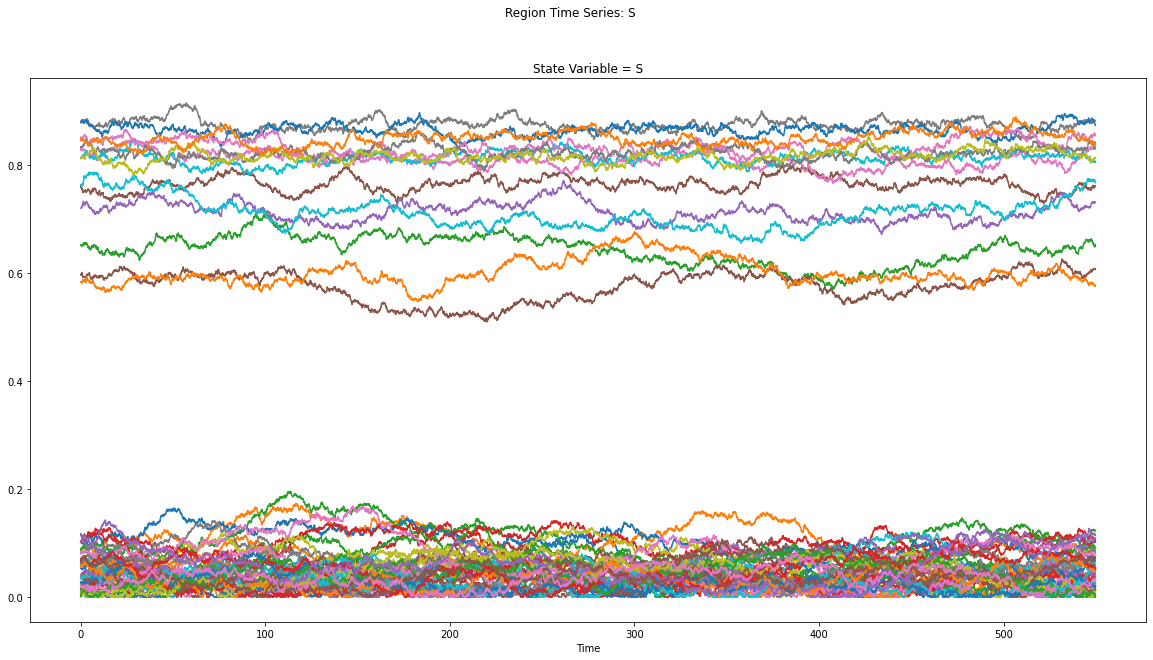

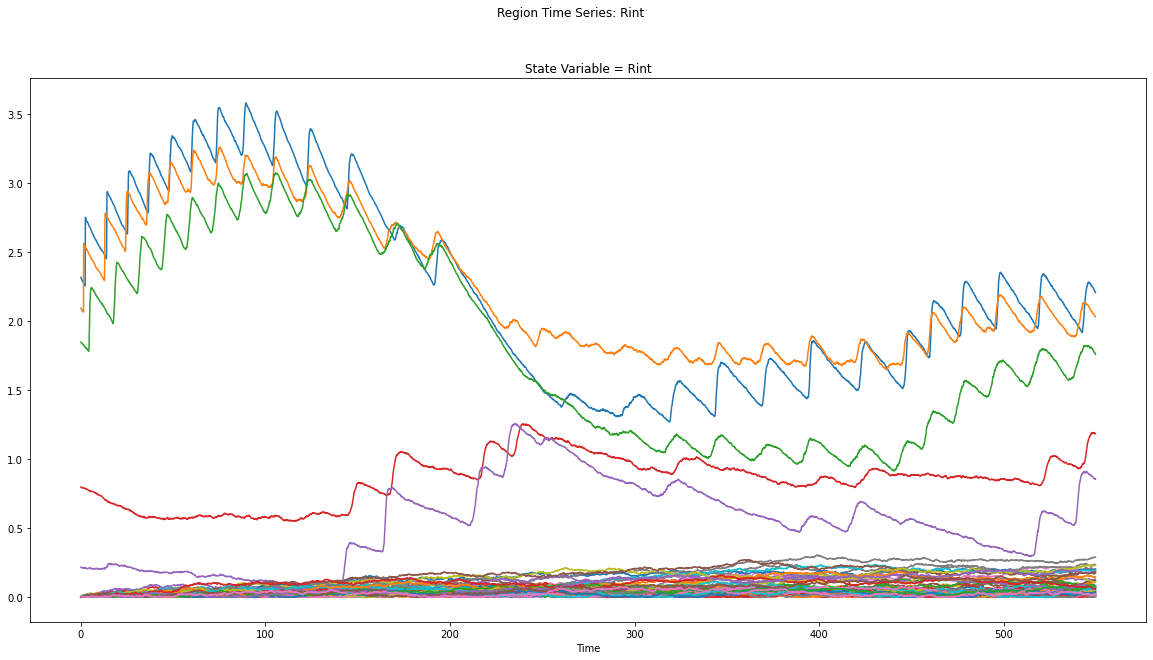

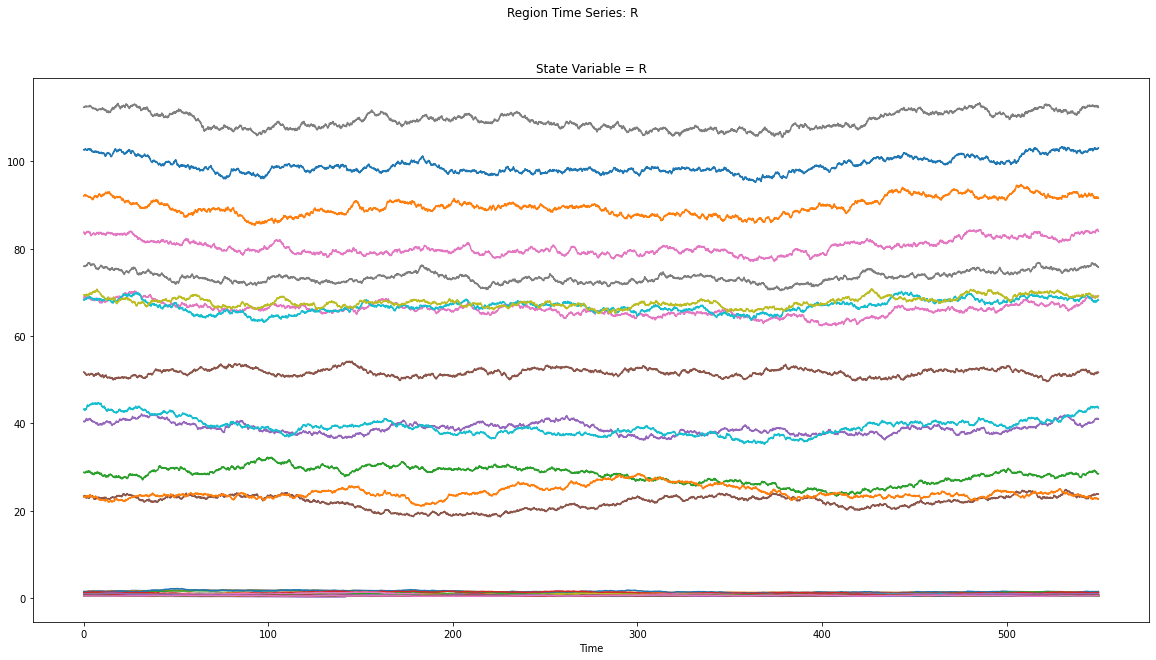

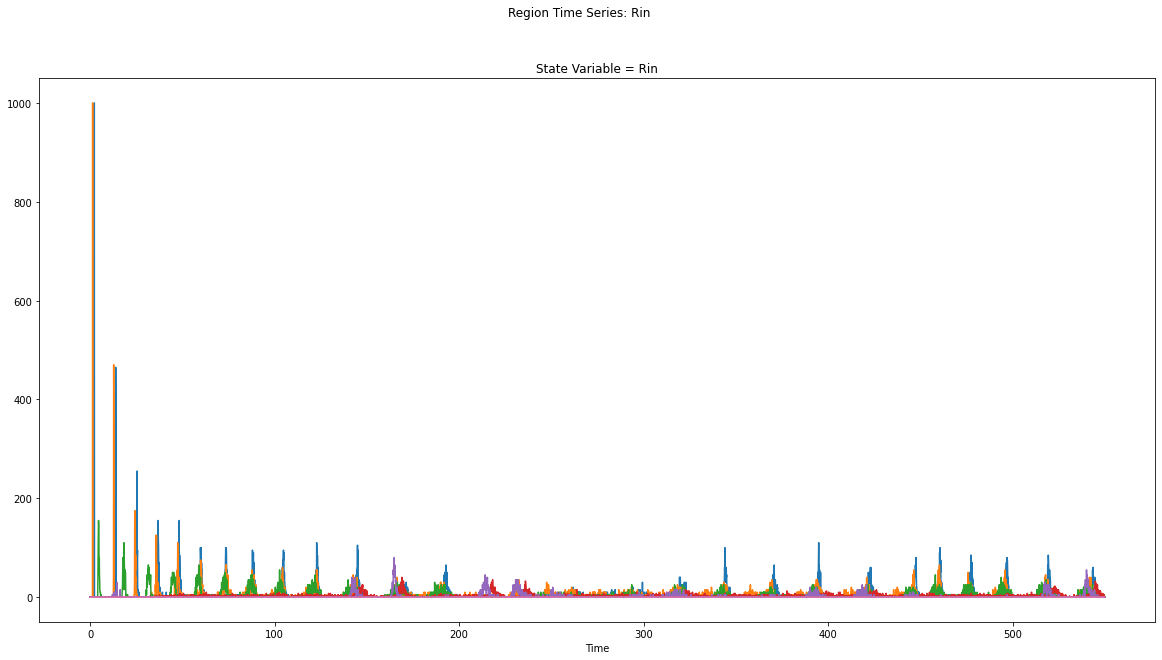

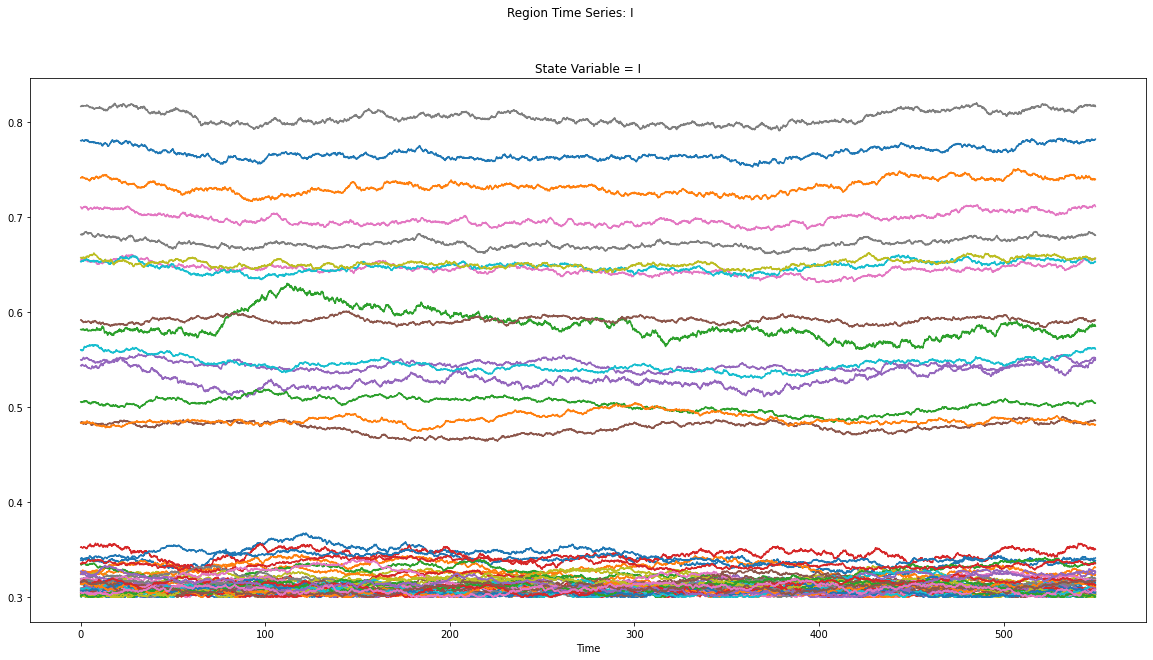

In [18]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

In [19]:
# # TVB time series raster plot:
# if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

2021-03-10 19:08:13,140 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 19:08:13,168 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 19:08:13,915 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 19:08:14,498 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 19:08:15,160 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 19:08:15,798 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


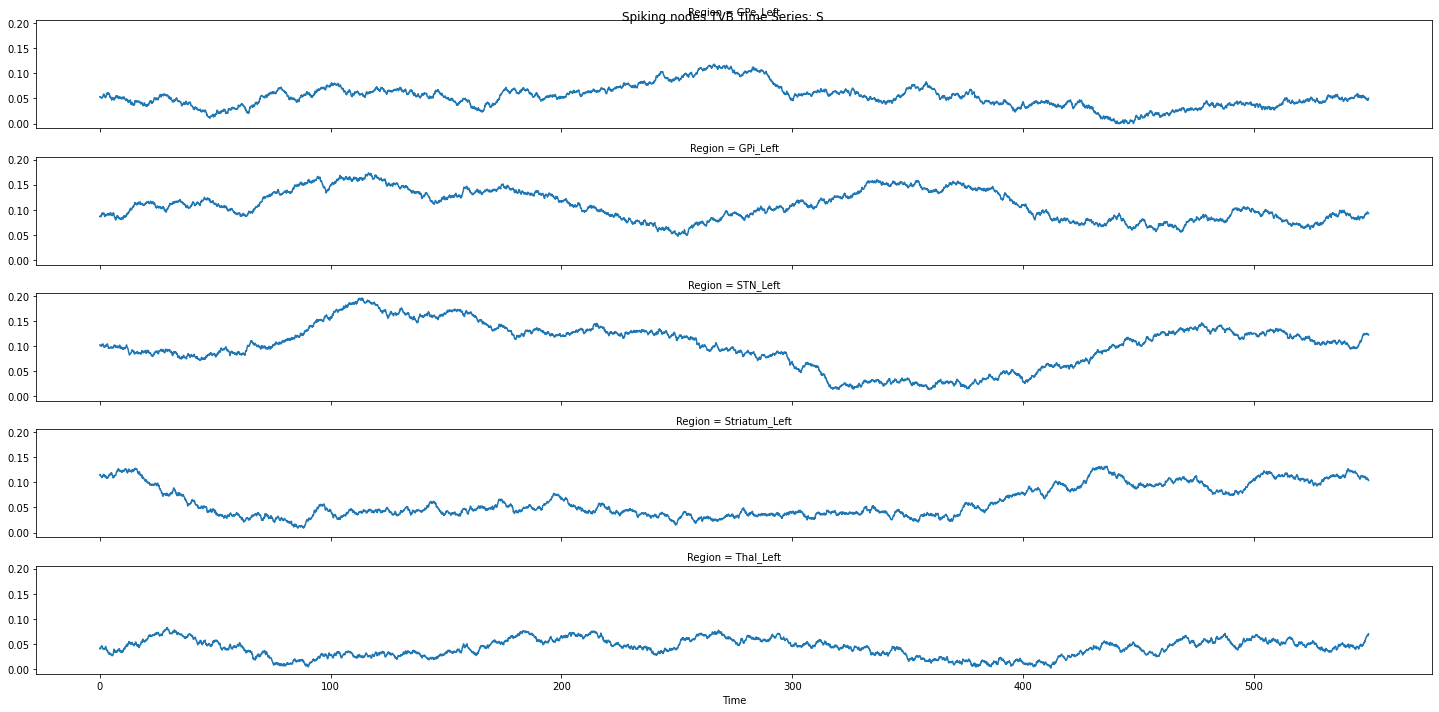

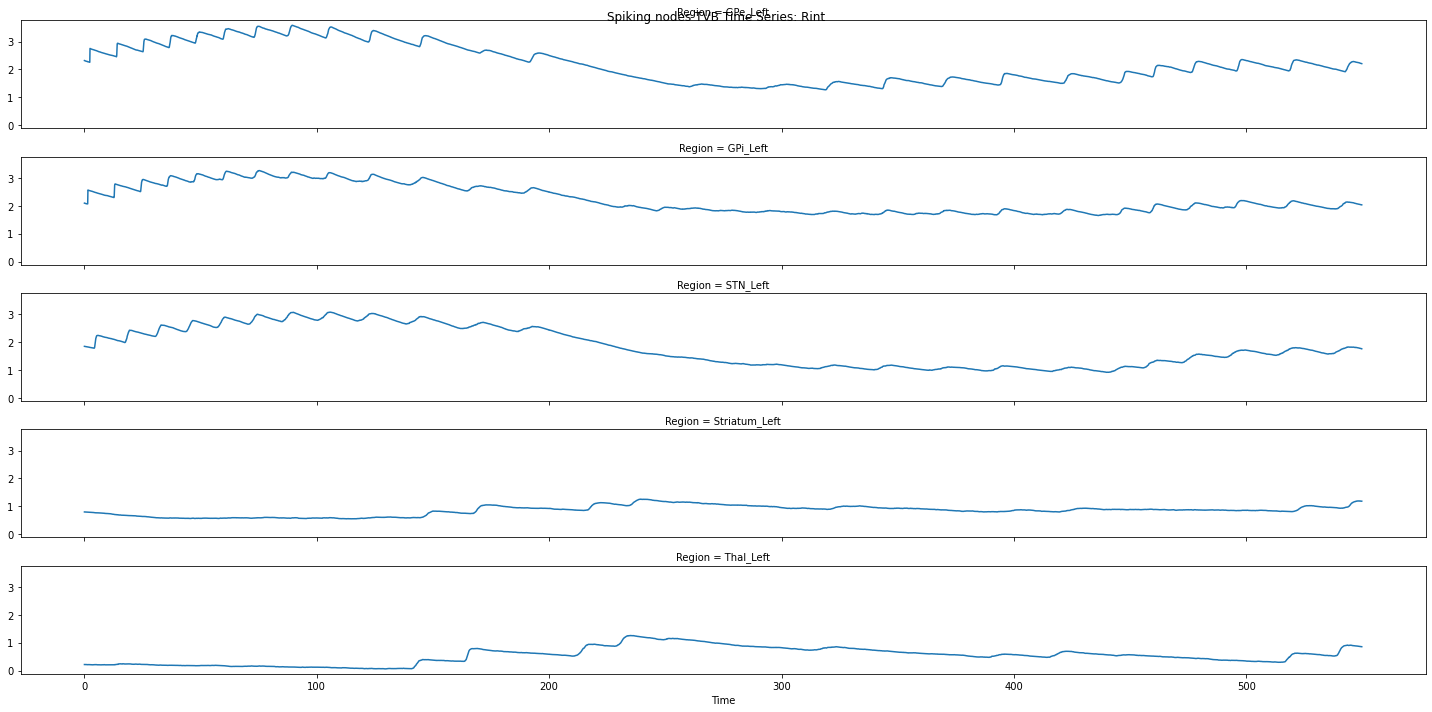

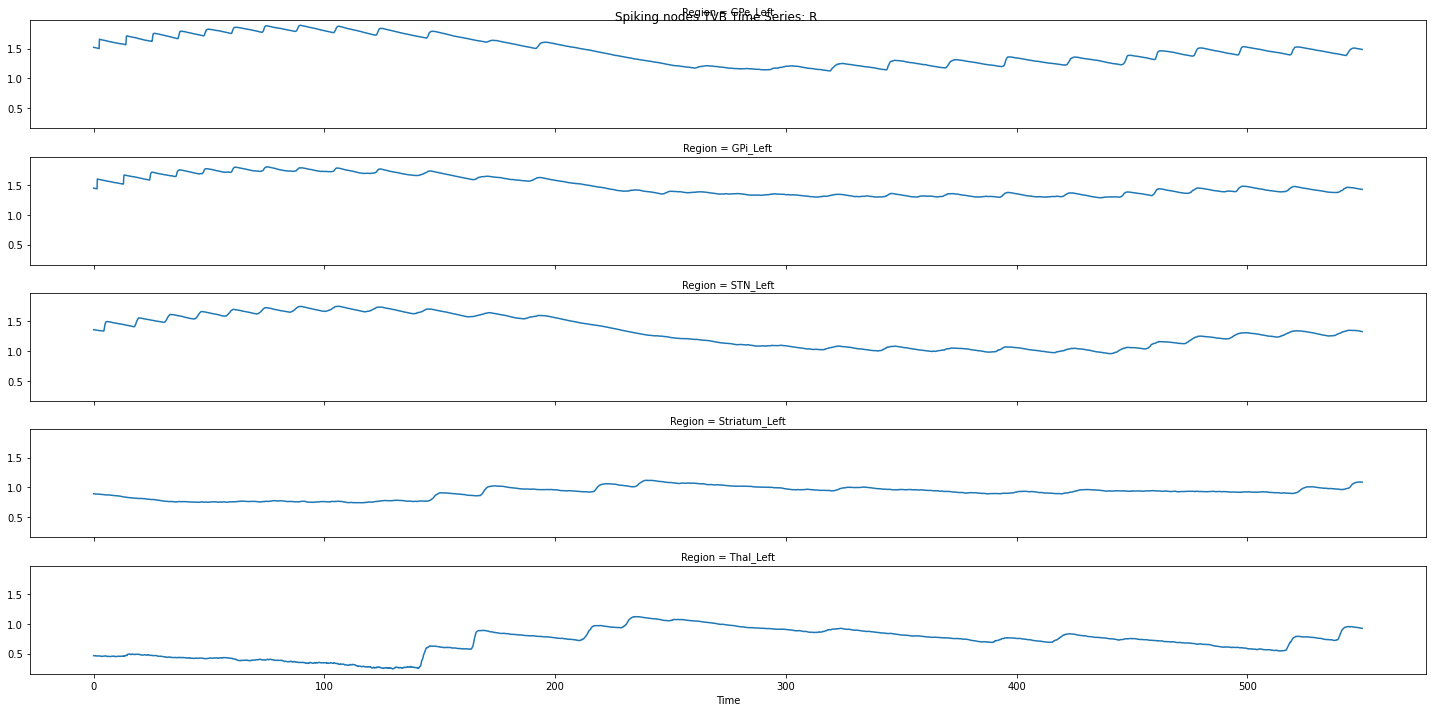

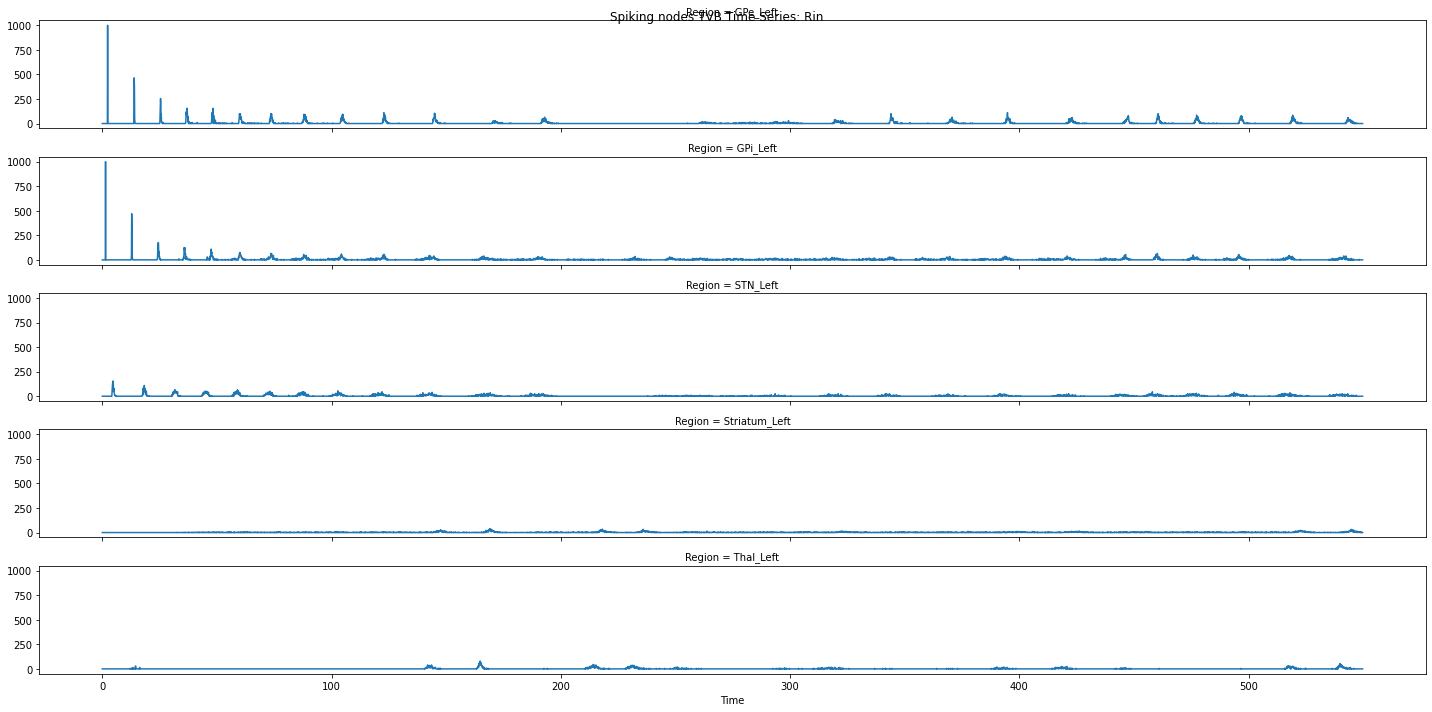

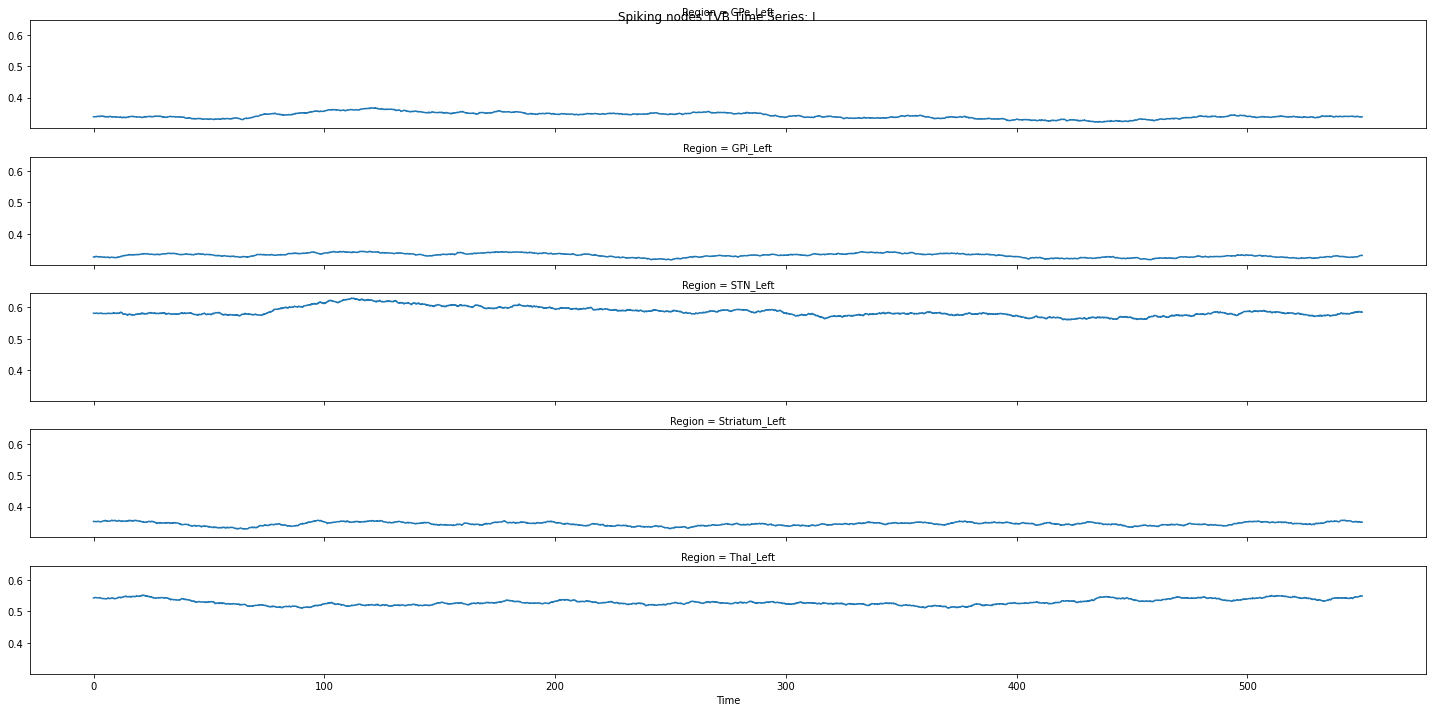

In [20]:
# Focus on the nodes modelled in ANNarchy: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
source_ts_ann = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
source_ts_ann.plot_timeseries(plotter_config=plotter.config, 
                               hue="Region" if source_ts_ann.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                               per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS, 
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [21]:
# # Focus on the nodes modelled in ANNarchy: raster plot
# if source_ts_ann.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_ann.plot_raster(plotter_config=plotter.config, 
#                                per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS,
#                                figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [22]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(TimeSeriesRegion().from_xarray_DataArray(source_ts._data, 
#                                                                              connectivity=source_ts.connectivity))

### Spiking Network plots

In [23]:
from tvb_multiscale.tvb_elephant.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=annarchy_network,
                           start_time=period, end_time=simulation_length, 
                           period=period, transient=transient,
                           time_series_output_type="TVB", return_data=True,
                           # elephant_mean_firing_rate=False,
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [24]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:848: UserWarning: Binning discarded 16 last spike(s) of the input spiketrain
  "input spiketrain".format(n_discarded))


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 4, Region: 5)>
array([[        nan,         nan, 25.70175426,         nan, 16.06516283],
       [32.43107753, 34.73684193,         nan,         nan,         nan],
       [        nan,         nan,         nan, 22.98245603,         nan],
       [        nan,         nan,         nan, 19.46115278,         nan]])
Coordinates:
  * Region      (Region) object 'GPe_Left' 'GPi_Left' ... 'Thal_Left'
  * Population  (Population) object 'E_spikes' 'I_spikes' ... 'IiSN_spikes'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 4, Population_j: 4, Region_i: 5, Region_j: 5)>
array([[[[        nan,         nan,         nan,         nan,
                  nan],
         [        nan,         nan,         nan,         nan,
                  nan],
         [        nan,         nan,  1.        ,         nan,
           0.1038558 ],
         [        nan,         nan,         nan,         nan,
                  nan],
 

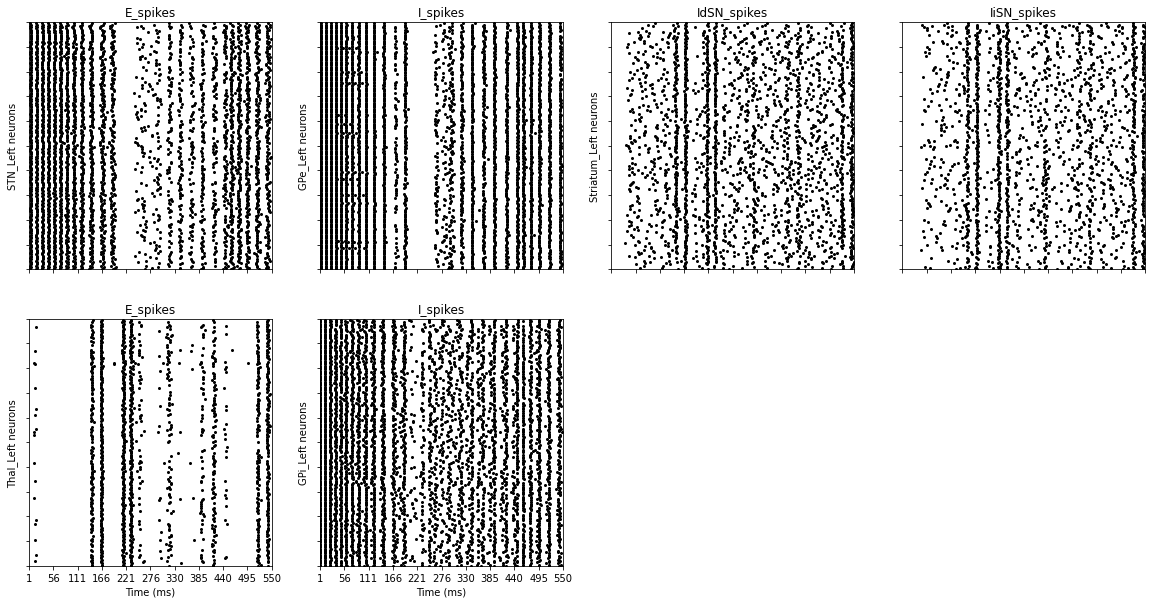

<Figure size 432x288 with 0 Axes>

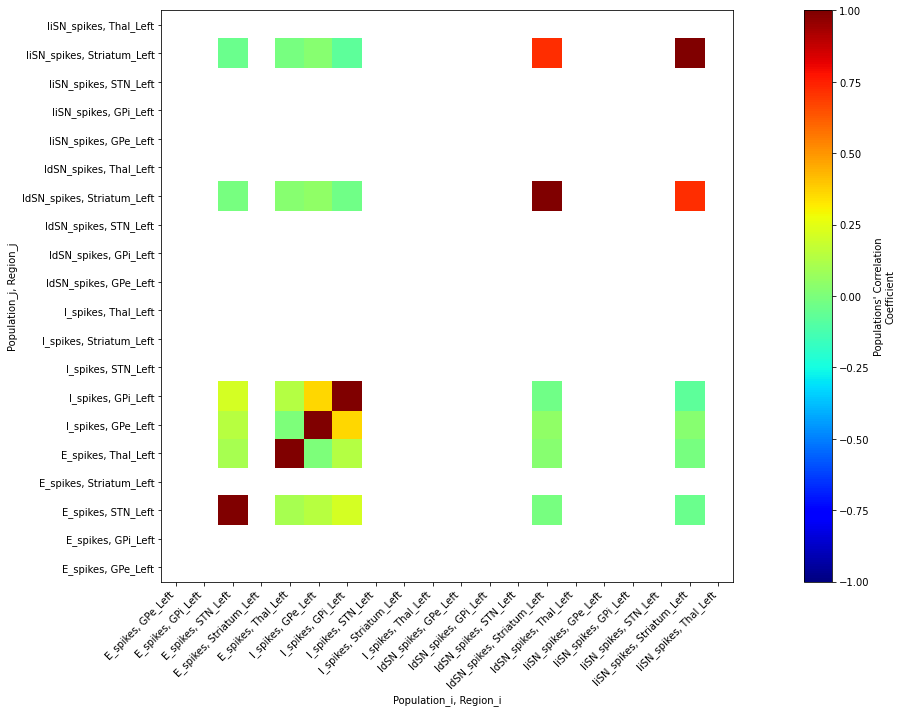

In [25]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], # rates=spikes_res["mean_rate_time_series"],
                                  figsize=FIGSIZE) #  
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [26]:
print("Mean spike rates:")
for pop in spikes_res["mean_rate"].coords["Population"]:
    for reg in spikes_res["mean_rate"].coords["Region"]:
        if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
            print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                   spikes_res["mean_rate"].loc[pop, reg].values.item()))

Mean spike rates:
E - STN_Left: 25.7018
E - Thal_Left: 16.0652
I - GPe_Left: 32.4311
I - GPi_Left: 34.7368
IdSN - Striatum_Left: 22.9825
IiSN - Striatum_Left: 19.4612


In [27]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

2021-03-10 19:08:23,443 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_annarchy/notebooks/outputs/outputs_Izhikevich_annarchy/TVBcortex/stim_STN/res/Spikes.h5
2021-03-10 19:08:23,443 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_annarchy/notebooks/outputs/outputs_Izhikevich_annarchy/TVBcortex/stim_STN/res/Spikes.h5
2021-03-10 19:08:23,529 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-03-10 19:08:23,529 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-03-10 19:08:23,536 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2021-03-10 19:08:23,536 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 fil

2021-03-10 19:08:24,034 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[123.25 148.75 170.3  ... 401.2  462.45 522.5 ] !

2021-03-10 19:08:24,034 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[123.25 148.75 170.3  ... 401.2  462.45 522.5 ] !

2021-03-10 19:08:24,041 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[  0   0   0 ... 199 199 199] !

2021-03-10 19:08:24,041 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[  0   0   0 ... 199 199 199] !

2021-03-10 19:08:24,083 - INFO - tvb_multiscale.core.io.h5_writer - dict has been written to

2021-03-10 19:08:24,572 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Populations' Correlation Coefficient.h5" (mode r+)> dataset <class 'numpy.ndarray'> dims:
['Population_i' 'Population_j' 'Region_i' 'Region_j'] !

2021-03-10 19:08:24,614 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Populations' Correlation Coefficient.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[[[        nan         nan         nan         nan         nan]
   [        nan         nan         nan         nan         nan]
   [        nan         nan  1.                 nan  0.1038558 ]
   [        nan         nan         nan         nan         nan]
   [        nan         nan  0.1038558          nan  1.        ]]

  [[        nan         nan         nan         nan         nan]
   [        nan         nan         nan         nan         nan]
   [ 0.14575436  0.21517036         nan         nan         nan]
   [        nan         nan        

2021-03-10 19:08:24,630 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-03-10 19:08:24,630 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-03-10 19:08:24,648 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-03-10 19:08:24,648 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-03-10 19:08:24,663 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2021-03-10 19:08:24,663 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2021-03-10 19:08:24,674 - WARNING - tvb_multisca

### Get  SpikingNetwork mean field variable time series and plot them

2021-03-10 19:08:26,883 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 19:08:28,111 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 19:08:29,062 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 19:08:30,150 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 19:08:31,038 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 19:08:32,170 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 19:08:33,157 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

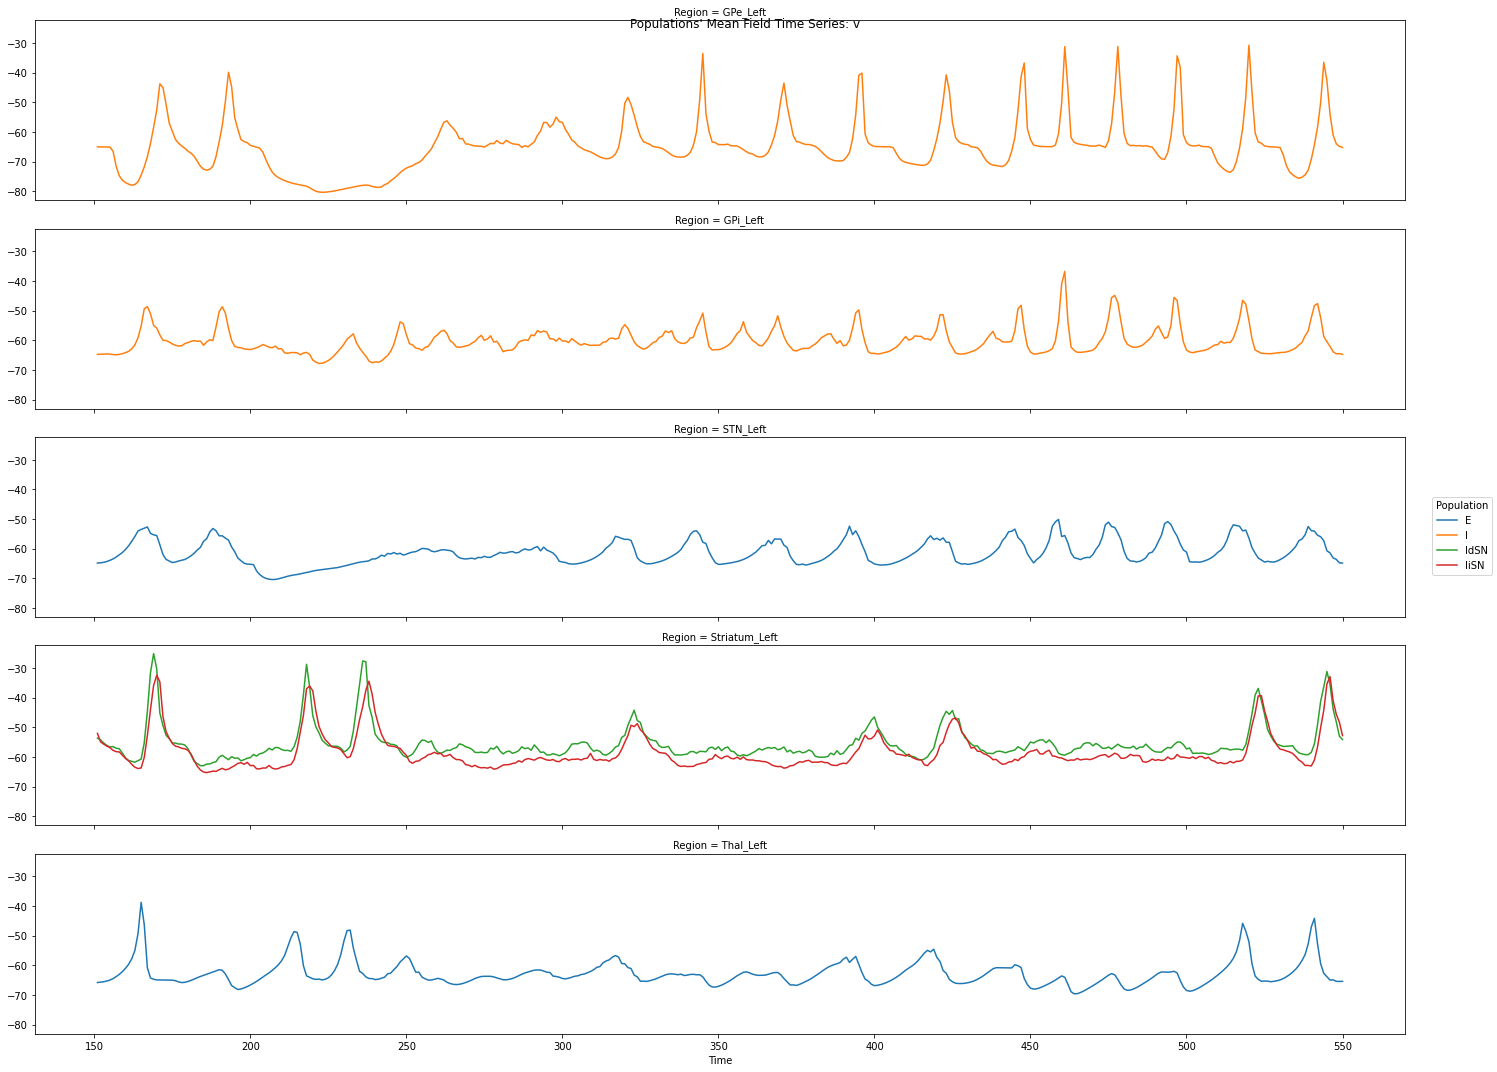

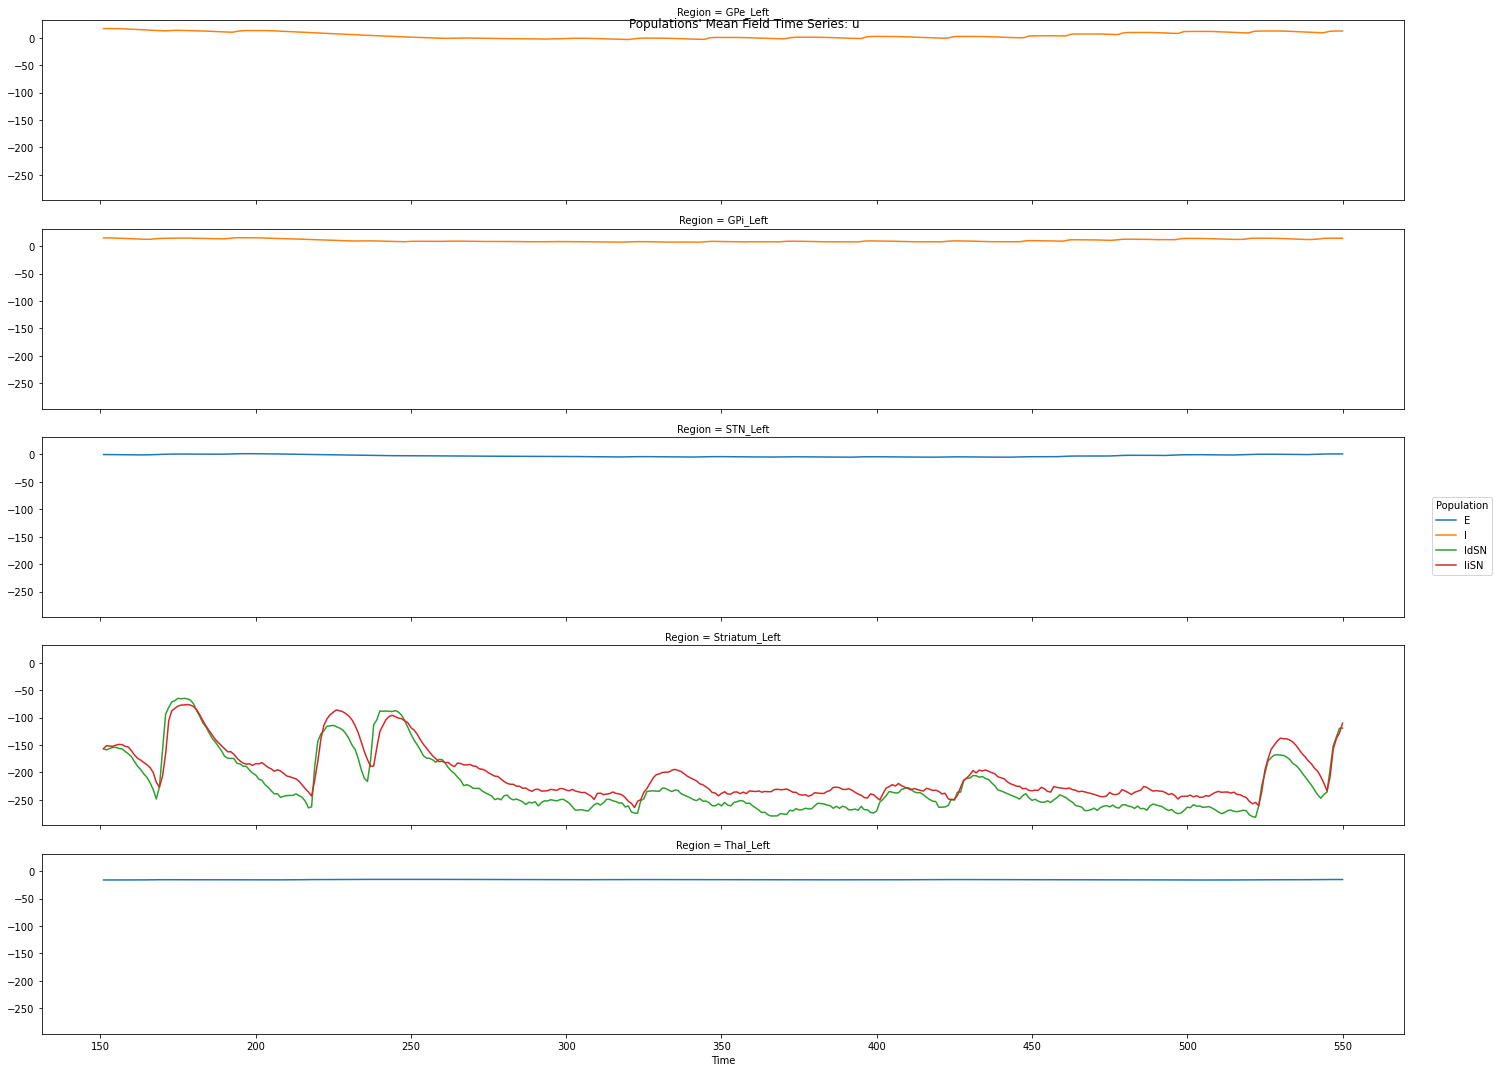

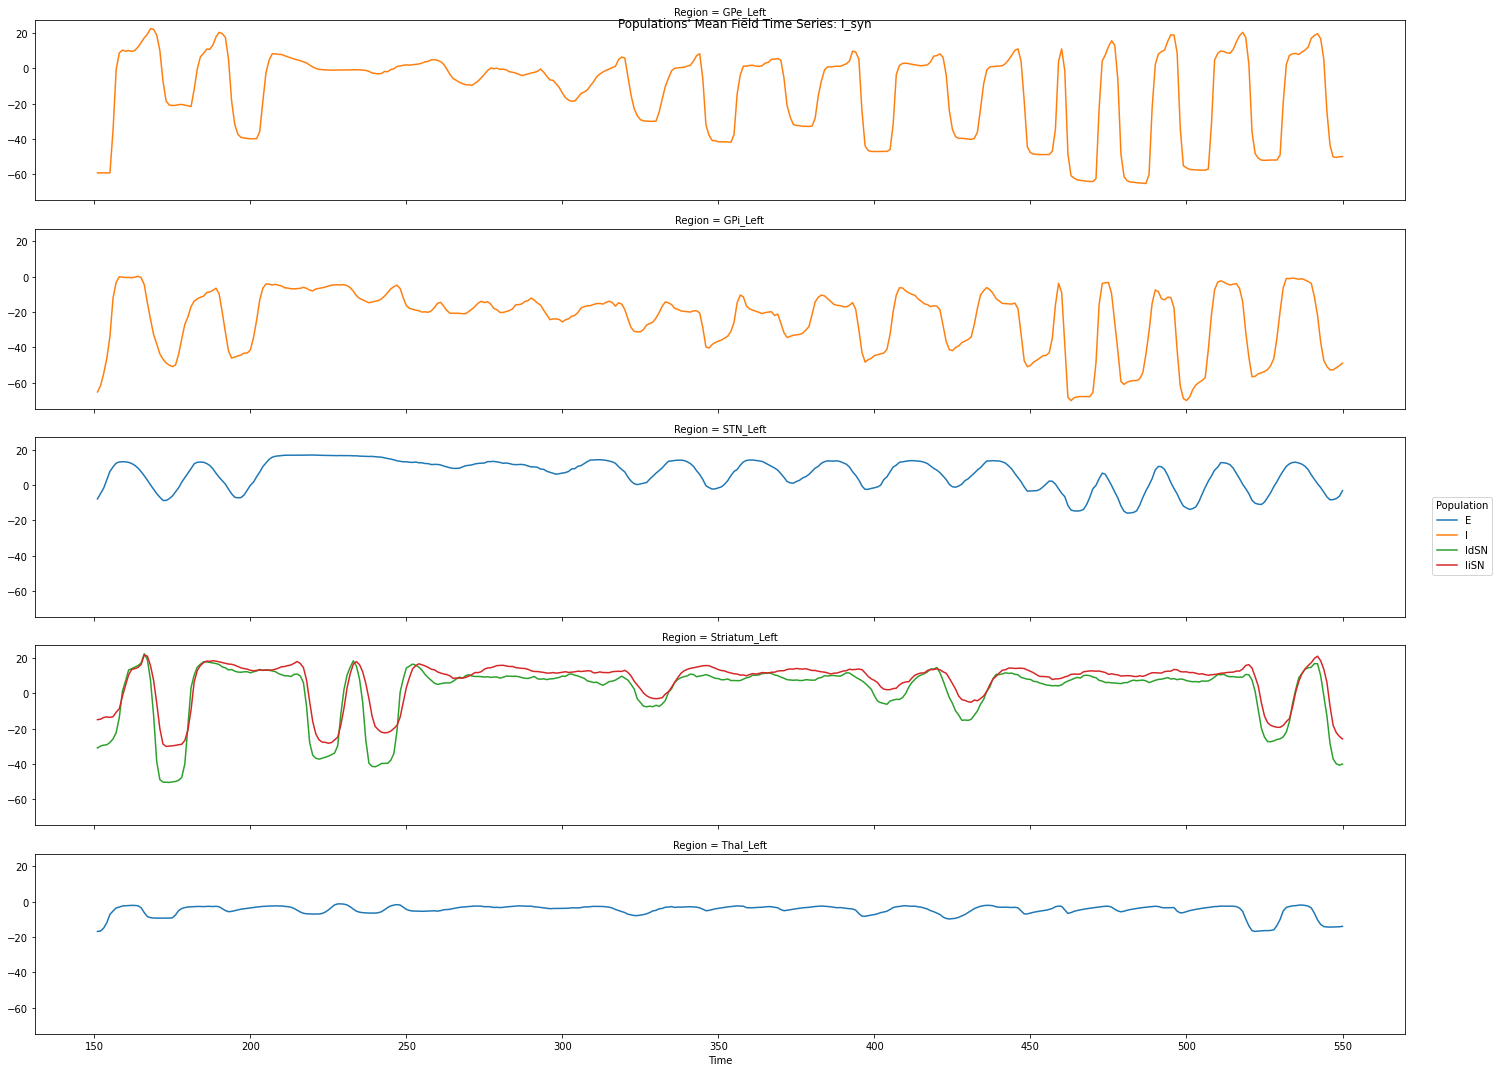

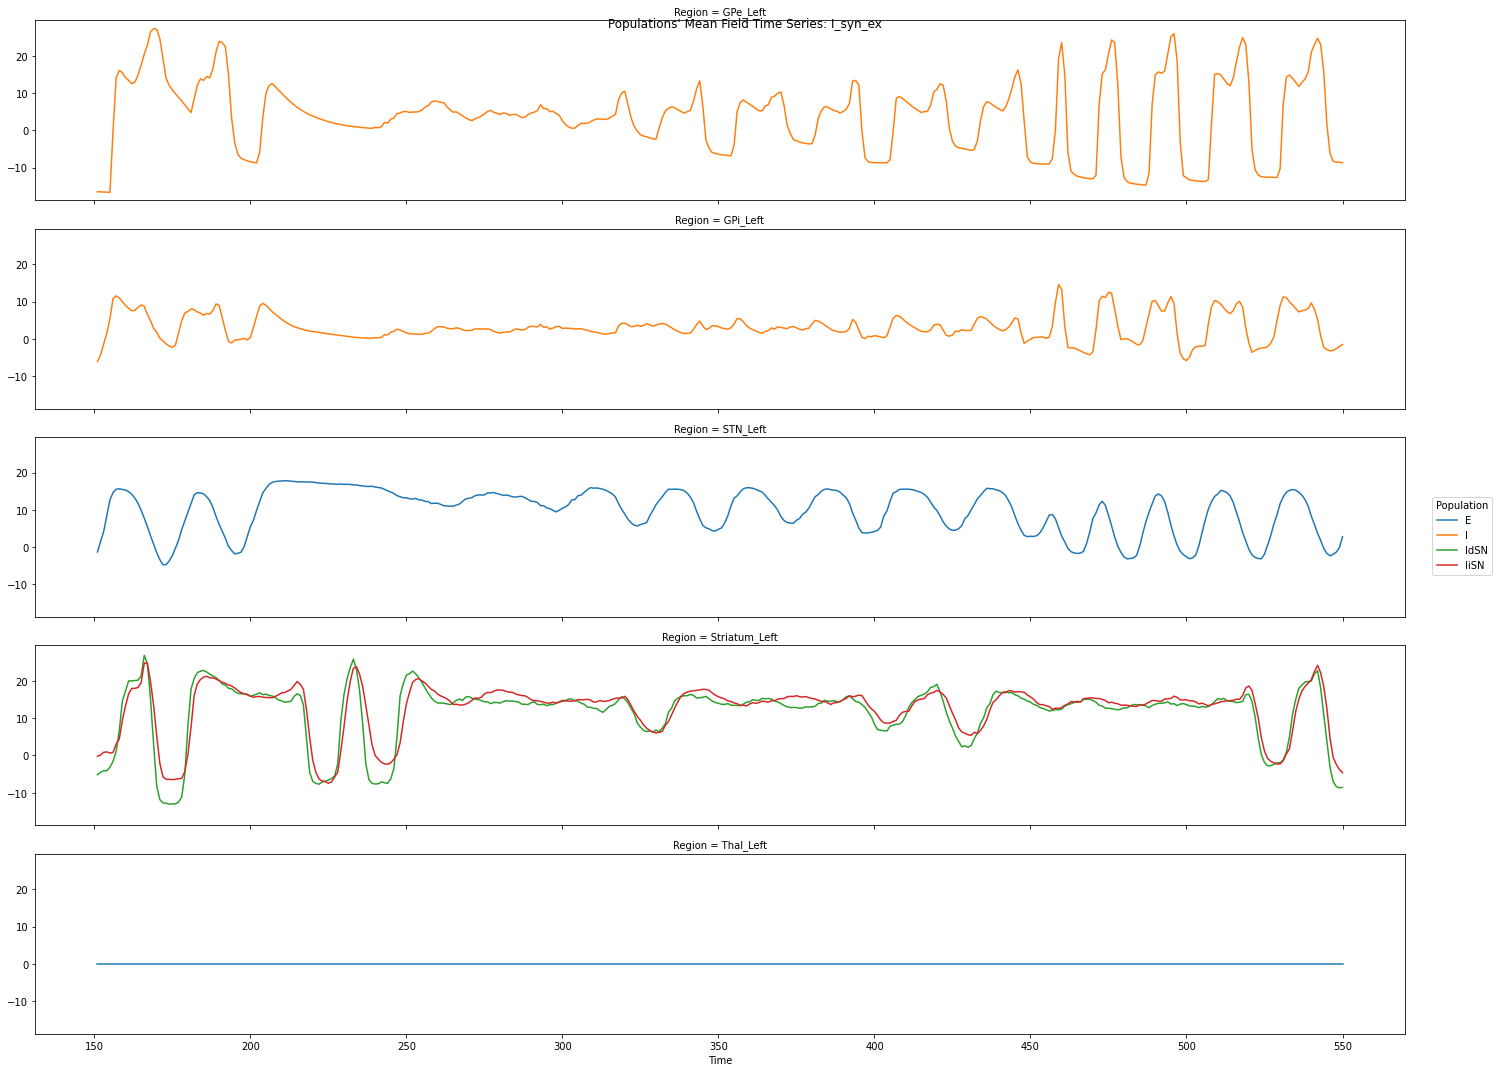

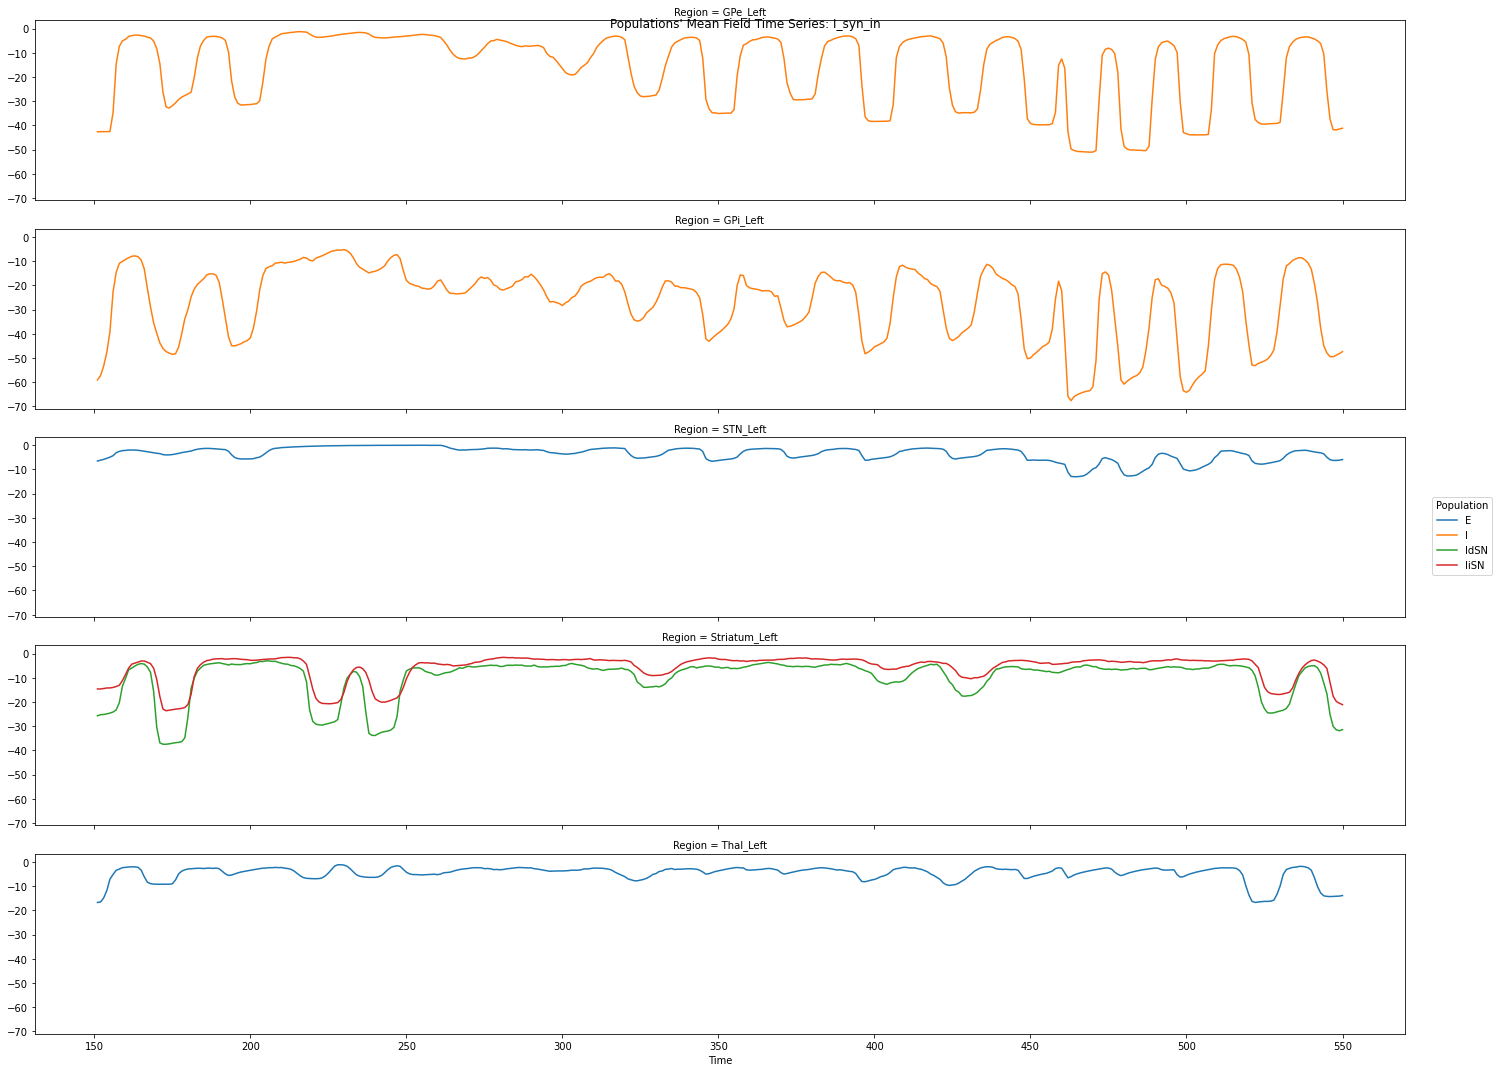

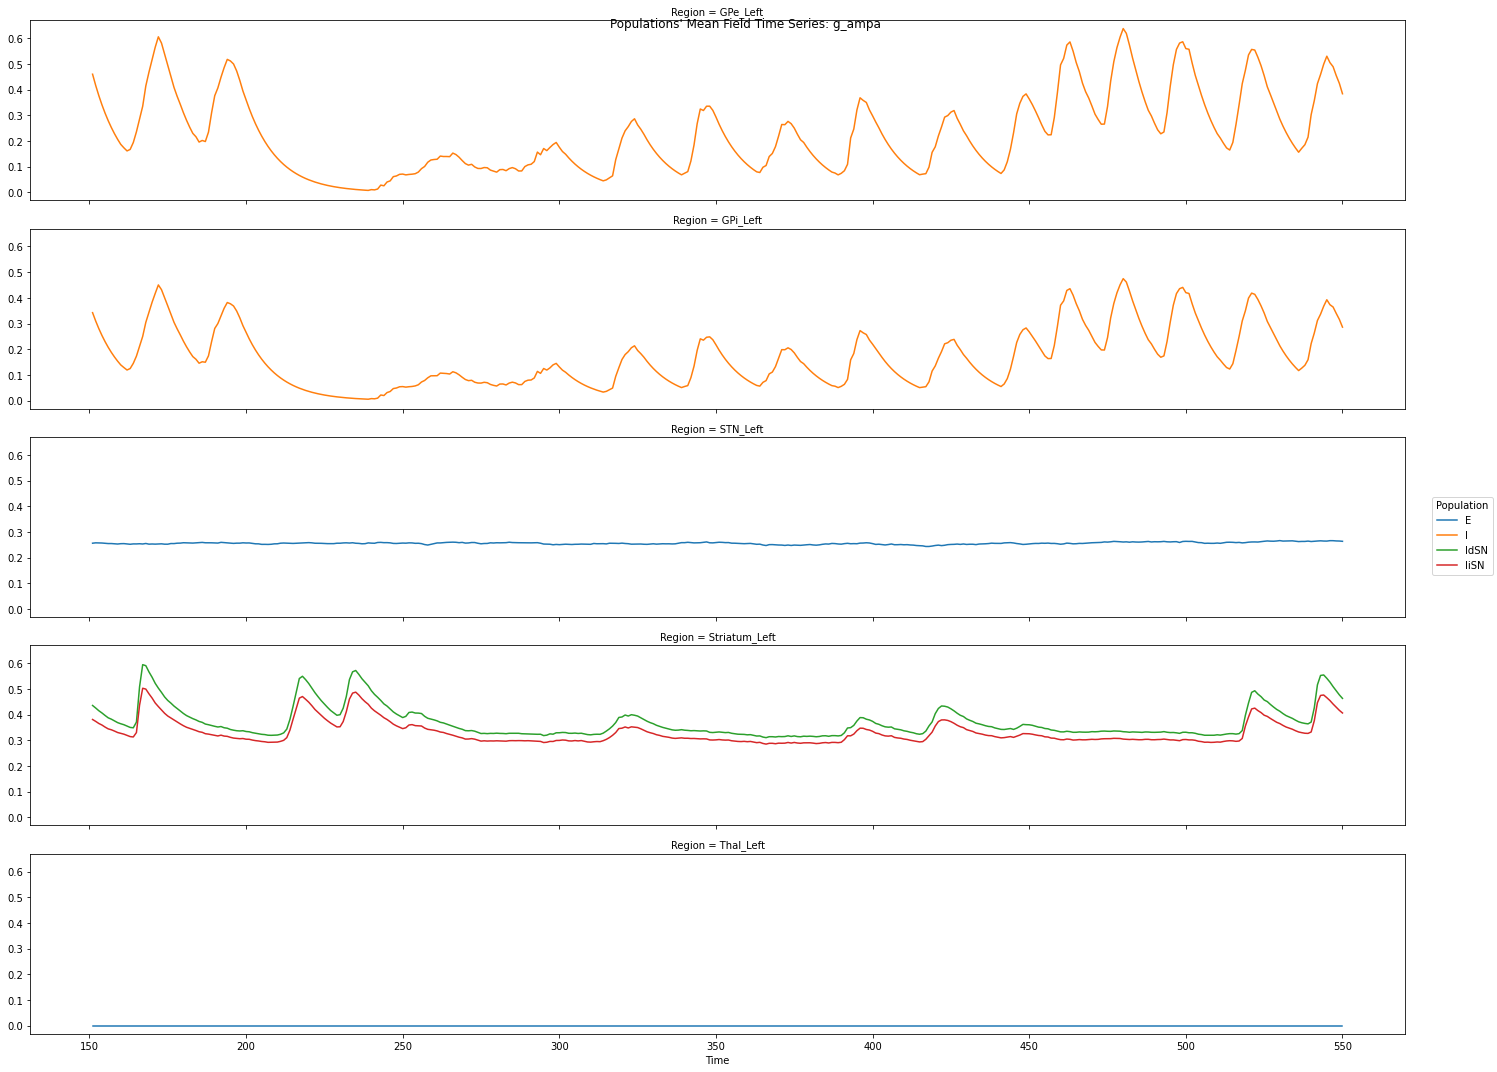

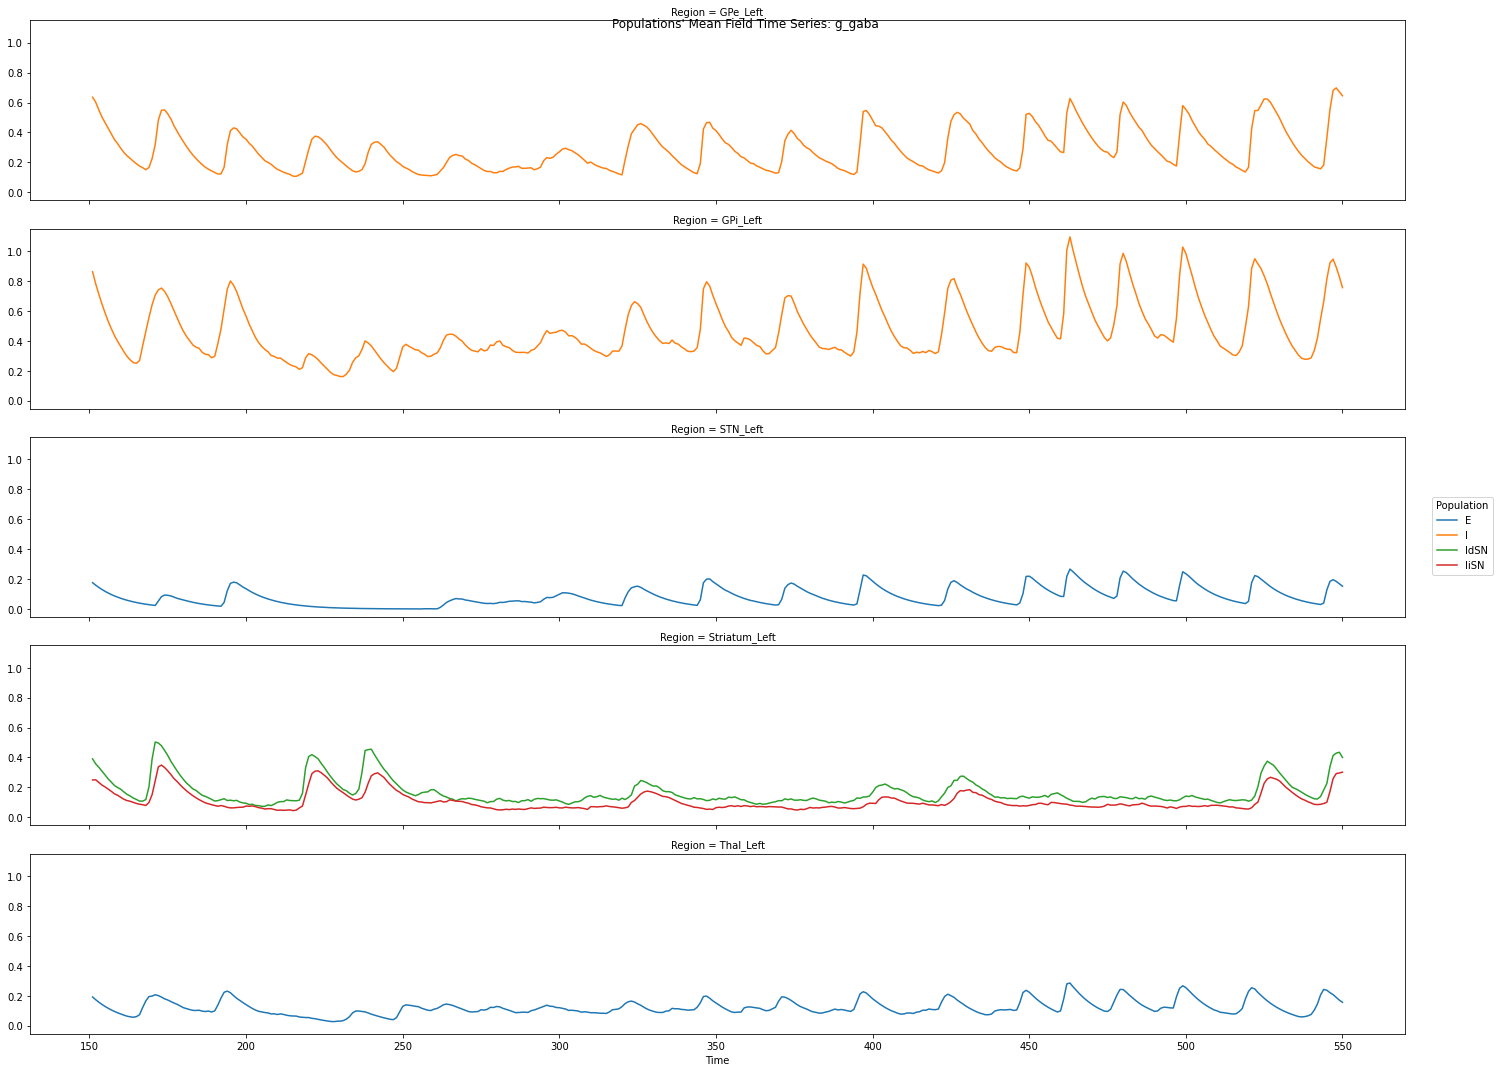

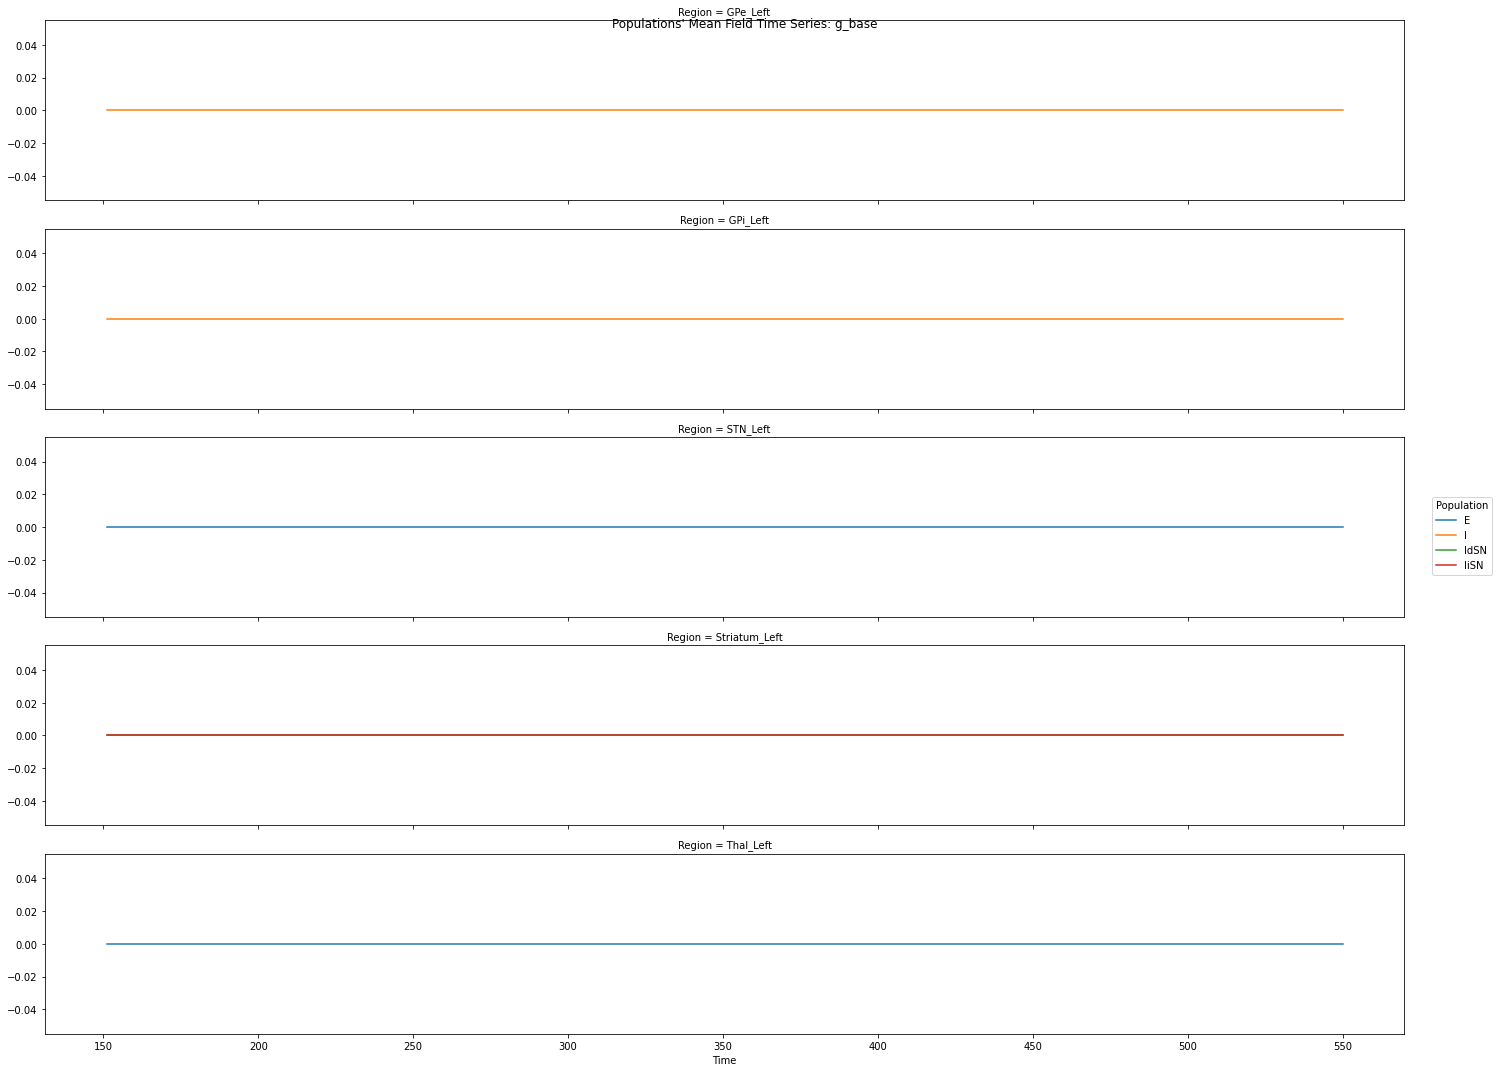

In [28]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [29]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [30]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [31]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Vitay J, Dinkelbach HÜ and Hamker FH (2015). <br>
  ANNarchy: a code generation approach to neural simulations on parallel hardware. <br>
  Frontiers in Neuroinformatics 9:19. doi:10.3389/fninf.2015.00019 <br>
  For more details see https://annarchy.readthedocs.io/en/latest/ <br>

4 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
5 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868

In [32]:
print("Configured connections:\n")

print("Within node's connections:")
for iP, pop in enumerate(ann_model_builder.populations_connections):
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["nodes"])
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["probability"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    print("%d. %s -> %s (%s) = %g (p=%g): %s (%g, %g)" 
          % (iP+1, pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))
    
print("\nAmong node's connections:")
for iP, pop in enumerate(ann_model_builder.nodes_connections):
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["source_nodes"], pop["target_nodes"]).item()
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["probability"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    print("%d. %s -> %s (%s) = %g (p=%g): %s (%g, %g)" 
          % (iP + 5, pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))
    
    
print("\nEffective connections:")
conns = ["GPeGPe", "GPiGPi", "dSNdSN", "iSNiSN", # "CtxICtxI", "CtxECtxI", "CtxICtxE", 
         "dSNGPi" , "iSNGPe", "GPeGPi", "GPiThal", "GPeSTN", "ThaldSN", "ThaliSN", 
         "STNGPe", "STNGPi"] # ,"CtxThal", "CtxSTN", "CtxdSN", "CtxiSN"
for iC, (name, proj) in enumerate(zip(conns, 
                                      annarchy_network.annarchy_instance.Global._network[0]["projections"])):
    meanNconns = np.mean([len(d.pre_ranks) for d in proj.dendrites])
    p = meanNconns / proj.pre.size
    print("%d. %s: %s w = %g (%g) (%s), effective_probability = %g (%g)" % 
          (iC+1, proj.name, name, proj.w, loadedParams["%s_weights" % name], proj.target,
            p, loadedParams["%s_probs" % name]))  # meanNconns = %g,  meanNconns,

Configured connections:

Within node's connections:
1. I -> I (gaba) = 0.00773167 (p=0.323896): GPeGPe (0.00773167, 0.323896)
2. I -> I (gaba) = 0.0119856 (p=0.317476): GPiGPi (0.0119856, 0.317476)
3. IdSN -> IdSN (gaba) = 0.0081135 (p=0.44881): dSNdSN (0.0081135, 0.44881)
4. IiSN -> IiSN (gaba) = 0.0139626 (p=0.204922): iSNiSN (0.0139626, 0.204922)

Among node's connections:
5. IdSN -> I (gaba) = 0.00913217 (p=0.170292): dSNGPi (0.00913217, 0.170292)
6. IiSN -> I (gaba) = 0.00766353 (p=0.407464): iSNGPe (0.00766353, 0.407464)
7. I -> I (gaba) = 0.0062383 (p=0.323173): GPeGPi (0.0062383, 0.323173)
8. I -> E (gaba) = 0.00665013 (p=0.259374): GPiThal (0.00665013, 0.259374)
9. I -> E (gaba) = 0.00676034 (p=0.184785): GPeSTN (0.00676034, 0.184785)
10. E -> IdSN (ampa) = 0.0122845 (p=0.127913): ThaldSN (0.0122845, 0.127913)
11. E -> IiSN (ampa) = 0.00698403 (p=0.175348): ThaliSN (0.00698403, 0.175348)
12. E -> I (ampa) = 0.0107546 (p=0.411954): STNGPe (0.0107546, 0.411954)
13. E -> I (ampa)

In [33]:
names = ["CtxSTN", "CtxdSN", "CtxiSN"]
weights = np.array([wCtxSTN, wCtxdSN, wCtxiSN])
iweights = np.array([iwCtxSTN, iwCtxdSN, iwCtxiSN])
probs = np.array([pCtxSTN, pCtxdSN, pCtxiSN])
wTVBs = tvb_annarchy_builder.global_coupling_scaling * np.array([iwCtxSTN * wTVBSTNs, iwCtxdSN * wTVBSNs, iwCtxiSN * wTVBSNs]).T
eff_weights = [[], [], []]
eff_probs = [[], [], []]
n_conn = -1
for iC, proj in enumerate(annarchy_network.annarchy_instance.Global._network[0]["projections"][13:]):
    if proj.w < 1:
        n_conn += 1
        i_node = n_conn % 52
        iN = int(np.floor(n_conn / 52).item())
        w = proj.w 
        name = names[iN]
        weight = weights[iN]
        prob = probs[iN]
        eff_weights[iN].append(w)
        meanNconns = np.mean([len(d.pre_ranks) for d in proj.dendrites])
        p = meanNconns / proj.pre.size
        eff_probs[iN].append(p)
        print("%d. %s: eff w = %g == %g (exp), eff p = %g ~= %g (exp)" % 
              (n_conn+1, proj.name, w, wTVBs[i_node][iN], p, prob))

print("\nIn total:")
for iN, (name, weight, prob, w, p) in enumerate(zip(names, weights, probs, eff_weights, eff_probs)):
    print("%d. (%d) %s: eff w = %g == %g (exp), eff p = %g (%g) ~= %g (exp)" % 
          (iN+1, len(w), name,  np.sum(w), tvb_annarchy_builder.global_coupling_scaling*weight, np.mean(p), np.std(p), prob))

1. R - Precentral_L -> E: eff w = 0.000515916 == 0.000515916 (exp), eff p = 0.168225 ~= 0.168288 (exp)
2. R - Frontal_Sup_2_L -> E: eff w = 0.000376474 == 0.000376474 (exp), eff p = 0.166033 ~= 0.168288 (exp)
3. R - Frontal_Mid_2_L -> E: eff w = 0.000699653 == 0.000699653 (exp), eff p = 0.168383 ~= 0.168288 (exp)
4. R - Frontal_Inf_Oper_L -> E: eff w = 2.73908e-05 == 2.73908e-05 (exp), eff p = 0.166967 ~= 0.168288 (exp)
5. R - Frontal_Inf_Tri_L -> E: eff w = 0.000209415 == 0.000209415 (exp), eff p = 0.167825 ~= 0.168288 (exp)
6. R - Frontal_Inf_Orb_2_L -> E: eff w = 0.000224569 == 0.000224569 (exp), eff p = 0.168217 ~= 0.168288 (exp)
7. R - Rolandic_Oper_L -> E: eff w = 2.06385e-05 == 2.06385e-05 (exp), eff p = 0.1699 ~= 0.168288 (exp)
8. R - Supp_Motor_Area_L -> E: eff w = 0.000183645 == 0.000183645 (exp), eff p = 0.169325 ~= 0.168288 (exp)
9. R - Olfactory_L -> E: eff w = 2.59328e-06 == 2.59328e-06 (exp), eff p = 0.169217 ~= 0.168288 (exp)
10. R - Frontal_Sup_Medial_L -> E: eff w = 0

93. R - Temporal_Mid_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.196058 ~= 0.195239 (exp)
94. R - Temporal_Pole_Mid_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.196442 ~= 0.195239 (exp)
95. R - Temporal_Inf_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.19545 ~= 0.195239 (exp)
96. R - Cerebelum_Crus1_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.195292 ~= 0.195239 (exp)
97. R - Cerebelum_Crus2_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.1934 ~= 0.195239 (exp)
98. R - Cerebelum_3_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.192858 ~= 0.195239 (exp)
99. R - Cerebelum_4_5_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.194633 ~= 0.195239 (exp)
100. R - Cerebelum_6_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.197283 ~= 0.195239 (exp)
101. R - Cerebelum_7b_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.196333 ~= 0.195239 (exp)
102. R - Cerebelum_8_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.1942 ~= 0.195239 (exp)
103. R - Cerebelum_9_L -> IdSN: eff w = 0 == 0 (exp), eff p = 0.194725 ~= 0.195239 (exp)
104. R - Cereb

In [34]:
rates = []
spikes = {}
for iR, region in enumerate(tvb_annarchy_model.tvb_to_spikeNet_interfaces[0].keys()):
    monitor = tvb_annarchy_model.tvb_to_spikeNet_interfaces[0][region]._record
    if spikes.get(region, False) == False:
        spikes[region] = monitor.get("spike").copy()
    spike_times, ranks = monitor.raster_plot(spikes[region].copy())
    if len(ranks):
        eff_spike_times = np.array(spike_times)[np.where(spike_times > transient)]
        rate = len(eff_spike_times) / np.unique(ranks).size / (simulation_length - transient) * 1000.0
    else:
        rate = 0.0
    rates.append(rate)
    print("%s rate = %g ~= %g (exp)" % (region, rate, TVBrate[iR]))
total_rate = np.sum(rates)
print("mean rate = %g (%g) ~= %g (exp)" % (np.mean(rates), total_rate /52, TVBrate.mean()))

Precentral_L rate = 51.0333 ~= 51.6 (exp)
Frontal_Sup_2_L rate = 65.9708 ~= 65.6581 (exp)
Frontal_Mid_2_L rate = 108.171 ~= 109.311 (exp)
Frontal_Inf_Oper_L rate = 2.2541 ~= 0.891326 (exp)
Frontal_Inf_Tri_L rate = 66.6167 ~= 67.102 (exp)
Frontal_Inf_Orb_2_L rate = 99.25 ~= 98.9938 (exp)
Rolandic_Oper_L rate = 2.05026 ~= 0.784045 (exp)
Supp_Motor_Area_L rate = 27.95 ~= 27.6451 (exp)
Olfactory_L rate = 2.21053 ~= 0.610087 (exp)
Frontal_Sup_Medial_L rate = 39.0333 ~= 38.7233 (exp)
Frontal_Med_Orb_L rate = 2.15278 ~= 0.663438 (exp)
Rectus_L rate = 80.3708 ~= 80.2386 (exp)
OFCmed_L rate = 74.25 ~= 73.4611 (exp)
OFCant_L rate = 67.7792 ~= 67.8212 (exp)
OFCpost_L rate = 38.6083 ~= 38.7393 (exp)
OFClat_L rate = 2.49235 ~= 1.44406 (exp)
Insula_L rate = 90.5667 ~= 89.9324 (exp)
Cingulate_Ant_L rate = 2.72177 ~= 1.00796 (exp)
Cingulate_Mid_L rate = 2.64062 ~= 1.27607 (exp)
Cingulate_Post_L rate = 2.06452 ~= 0.616477 (exp)
Hippocampus_L rate = 2.2093 ~= 0.650173 (exp)
ParaHippocampal_L rate = 2.03